# Basic EDA and Visualization

1. Understanding the datasets - Basic infos
2. Data Quality Checks
    1. Missing Value
    2. Outlier Check
    3. Dataset column type checks
3. Univariate, BiVariate and Visualization

In [67]:
#loading the required packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import plotnine as p9 
import seaborn as sns
from scipy import stats
from mizani.formatters import percent_format

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 


In [68]:
#Fetching the data
raw_data = pd.read_csv('./data/tesco-dataset/train.csv')
print('The shape of the dataset :' + str(raw_data.shape))
raw_data.head()

The shape of the dataset :(320, 16)


,location_id,crime_rate,proportion_flats,proportion_nonretail,new_store,commercial_property,household_size,proportion_newbuilds,public_transport_dist,transport_availability,property_value,school_proximity,competitor_density,household_affluency,normalised_sales,county
0,464,17.600541,0.0,18.10,no,NaN,2.926,29.0,2.9084,All transport options,666,20.2,368.74,4.5325,-0.399933,c_40
1,504,0.603556,20.0,3.97,no,14.85,4.520,10.6,2.1398,Average transport options,264,13.0,388.37,1.8150,2.216308,c_80
2,295,0.606810,0.0,6.20,no,7.70,2.981,31.9,3.6715,Many transport options,307,17.4,378.35,2.9125,0.166920,c_53
3,187,0.012385,55.0,2.25,no,1.95,3.453,68.1,7.3073,No transport options,300,15.3,394.72,2.0575,-0.083804,c_65
4,193,0.016182,100.0,1.32,no,3.05,3.816,59.5,8.3248,Average transport options,256,15.1,392.90,0.9875,0.962693,c_97


## Checking dtype

In [69]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   location_id             320 non-null    int64  
 1   crime_rate              320 non-null    float64
 2   proportion_flats        320 non-null    float64
 3   proportion_nonretail    320 non-null    float64
 4   new_store               320 non-null    object 
 5   commercial_property     291 non-null    float64
 6   household_size          320 non-null    float64
 7   proportion_newbuilds    320 non-null    float64
 8   public_transport_dist   320 non-null    float64
 9   transport_availability  320 non-null    object 
 10  property_value          320 non-null    int64  
 11  school_proximity        257 non-null    float64
 12  competitor_density      320 non-null    float64
 13  household_affluency     320 non-null    float64
 14  normalised_sales        320 non-null    fl

## Categorical data


In [70]:
raw_data["new_store"].value_counts()
# Binary encoding for new_store feature

new_store
no     301
yes     19
Name: count, dtype: int64

### Comments on new_store column:  
1. This has only 2 values.
2. Should be converted into boolean column

In [6]:
raw_data["transport_availability"].value_counts()
# Ordinal encoding for transport_availability feature

transport_availability
All transport options        84
Average transport options    72
Few transport options        69
No transport options         53
Many transport options       42
Name: count, dtype: int64

### Comments on transport_availability column:  
1. Looks like ordinal column. 
2. Should be converted into an ordered column in this order
    1. All transport options > Many transport options > Average transport options > Few transport options > No transport options.

In [7]:
raw_data["county"].value_counts().tail(50)

county
c_128    2
c_28     2
c_93     2
c_92     2
c_37     2
c_34     2
c_30     2
c_116    2
c_40     2
c_43     2
c_90     2
c_31     2
c_51     2
c_47     2
c_98     2
c_36     2
c_95     2
c_81     2
c_85     2
c_75     2
c_133    1
c_112    1
c_21     1
c_32     1
c_123    1
c_91     1
c_122    1
c_0      1
c_110    1
c_79     1
c_114    1
c_15     1
c_33     1
c_20     1
c_137    1
c_97     1
c_22     1
c_16     1
c_89     1
c_103    1
c_138    1
c_96     1
c_100    1
c_144    1
c_9      1
c_111    1
c_107    1
c_7      1
c_139    1
c_99     1
Name: count, dtype: int64

### Comments on county column:
1. High cardinality
2. Considering only top 10 columns and remaining columns as 'others' - This is an option
3. Have to check correlation with sales to gain more clarity

#### Further analysis on county column

#### Checking if there is correlation between frequency and sales in the county

In [8]:
freq=raw_data["county"].value_counts()

sales=(raw_data
 .groupby("county")
 .aggregate({"normalised_sales":"mean"})
 .reset_index()
)

merged_df=pd.merge(freq,sales,on="county" )

merged_df["count"].corr(merged_df["normalised_sales"])

-0.3244946825682793

* No correlation 

Considering only top 10 columns and remaining columns as 'others'

#### Approach for handling "county":

* Going with Target variable based grouping - high, medium, low - with respect to sales


## Feature Engineering

In [71]:
raw_data.columns

Index(['location_id', 'crime_rate', 'proportion_flats', 'proportion_nonretail',
       'new_store', 'commercial_property', 'household_size',
       'proportion_newbuilds', 'public_transport_dist',
       'transport_availability', 'property_value', 'school_proximity',
       'competitor_density', 'household_affluency', 'normalised_sales',
       'county'],
      dtype='object')

1. newbuild_property_value=proportion_newbuilds * property_value
2. flats_property_value = proportion_flats * property_value
3. commercial_property_value=commercial_property*property_value
4. senseful_school_proximity=school_proximity*proportion_flats
5. flats_crime_rate = proportion_flats*crime_rate

In [72]:
raw_data['newbuild_property_value']=raw_data['proportion_newbuilds']*raw_data['property_value']
raw_data['flats_property_value']=raw_data['proportion_flats']*raw_data['property_value']
raw_data['commercial_property_value']=raw_data['commercial_property']*raw_data['property_value']
raw_data['senseful_school_proximity']=raw_data['school_proximity']*raw_data['proportion_flats']
raw_data['flats_crime_rate']=raw_data['proportion_flats']*raw_data['crime_rate']


## Numerical columns

### Univariate analysis

In [76]:
# Fetching numerical columns
numerical_columns=raw_data.select_dtypes(include=['int64', 'float64']).columns.to_list()
numerical_columns.remove('location_id')

In [77]:
raw_data.head()

,location_id,crime_rate,proportion_flats,proportion_nonretail,new_store,commercial_property,household_size,proportion_newbuilds,public_transport_dist,transport_availability,...,school_proximity,competitor_density,household_affluency,normalised_sales,county,newbuild_property_value,flats_property_value,commercial_property_value,senseful_school_proximity,flats_crime_rate
0,464,17.600541,0.0,18.10,no,NaN,2.926,29.0,2.9084,All transport options,...,20.2,368.74,4.5325,-0.399933,c_40,19314.0,0.0,NaN,0.0,0.000000
1,504,0.603556,20.0,3.97,no,14.85,4.520,10.6,2.1398,Average transport options,...,13.0,388.37,1.8150,2.216308,c_80,2798.4,5280.0,3920.4,260.0,12.071112
2,295,0.606810,0.0,6.20,no,7.70,2.981,31.9,3.6715,Many transport options,...,17.4,378.35,2.9125,0.166920,c_53,9793.3,0.0,2363.9,0.0,0.000000
3,187,0.012385,55.0,2.25,no,1.95,3.453,68.1,7.3073,No transport options,...,15.3,394.72,2.0575,-0.083804,c_65,20430.0,16500.0,585.0,841.5,0.681164
4,193,0.016182,100.0,1.32,no,3.05,3.816,59.5,8.3248,Average transport options,...,15.1,392.90,0.9875,0.962693,c_97,15232.0,25600.0,780.8,1510.0,1.618160


### Outlier check

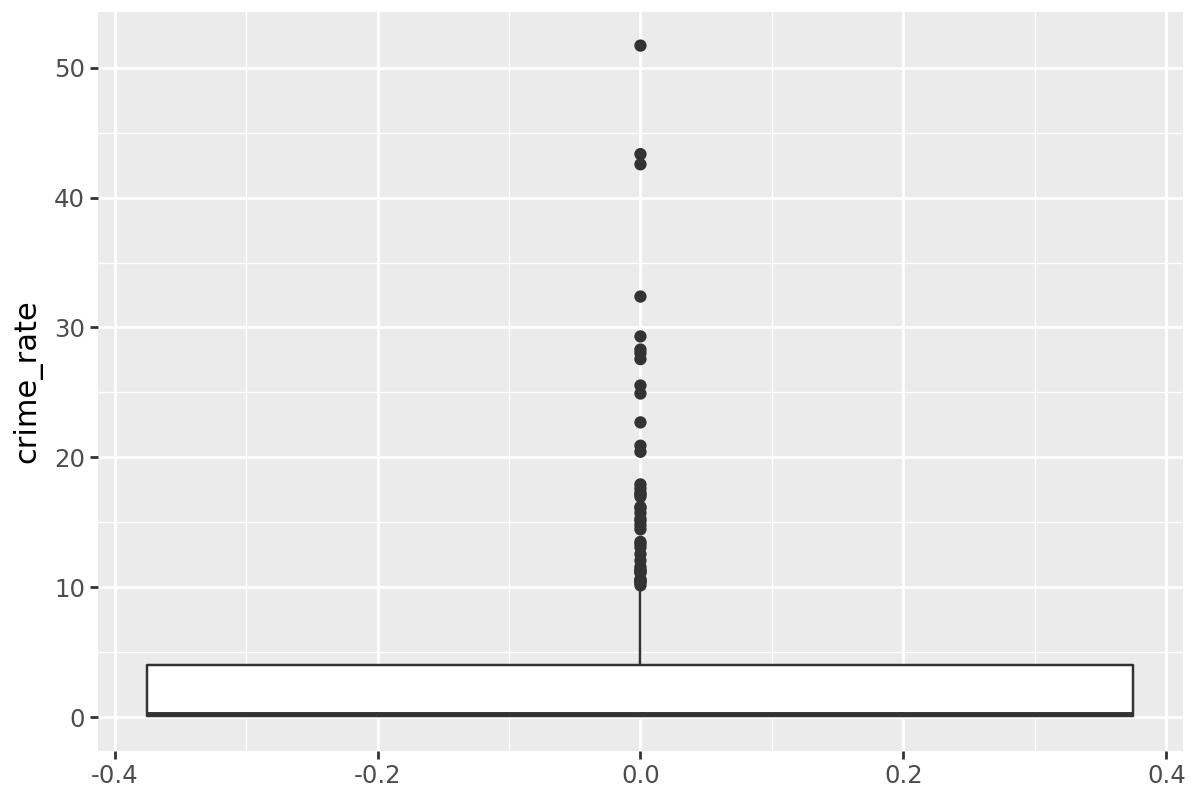

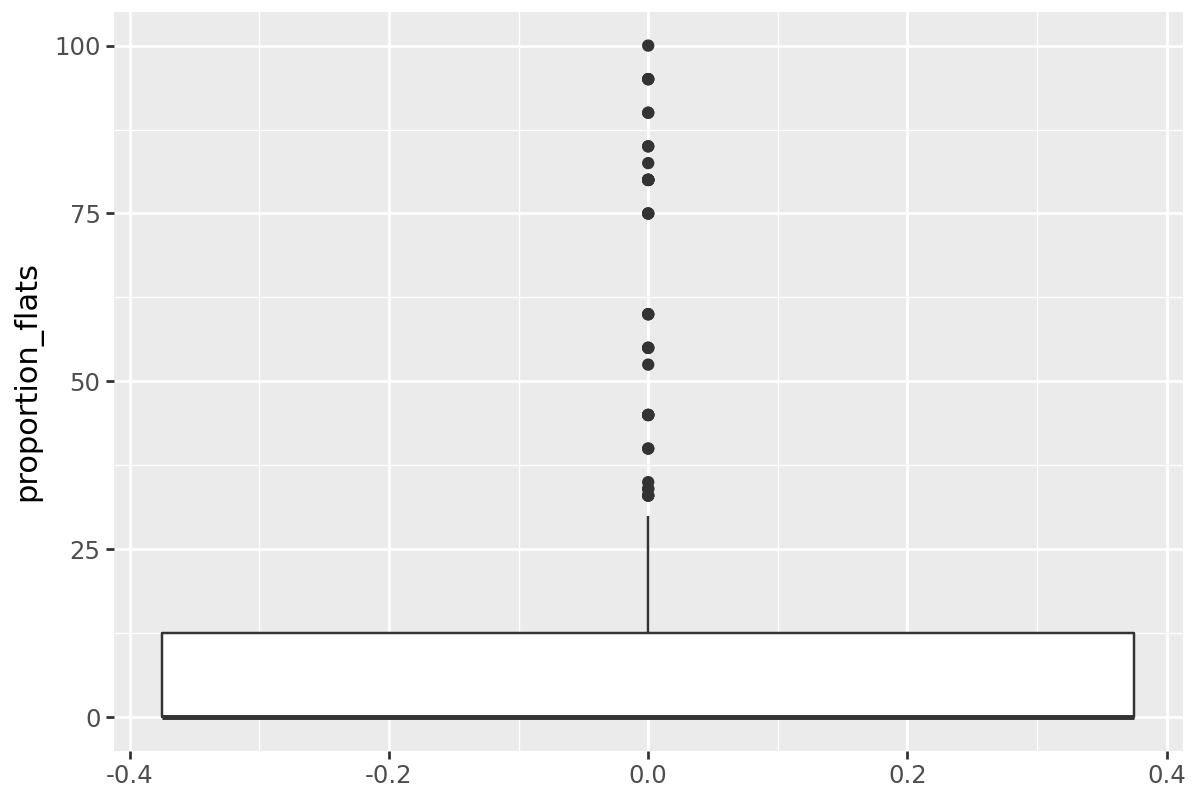

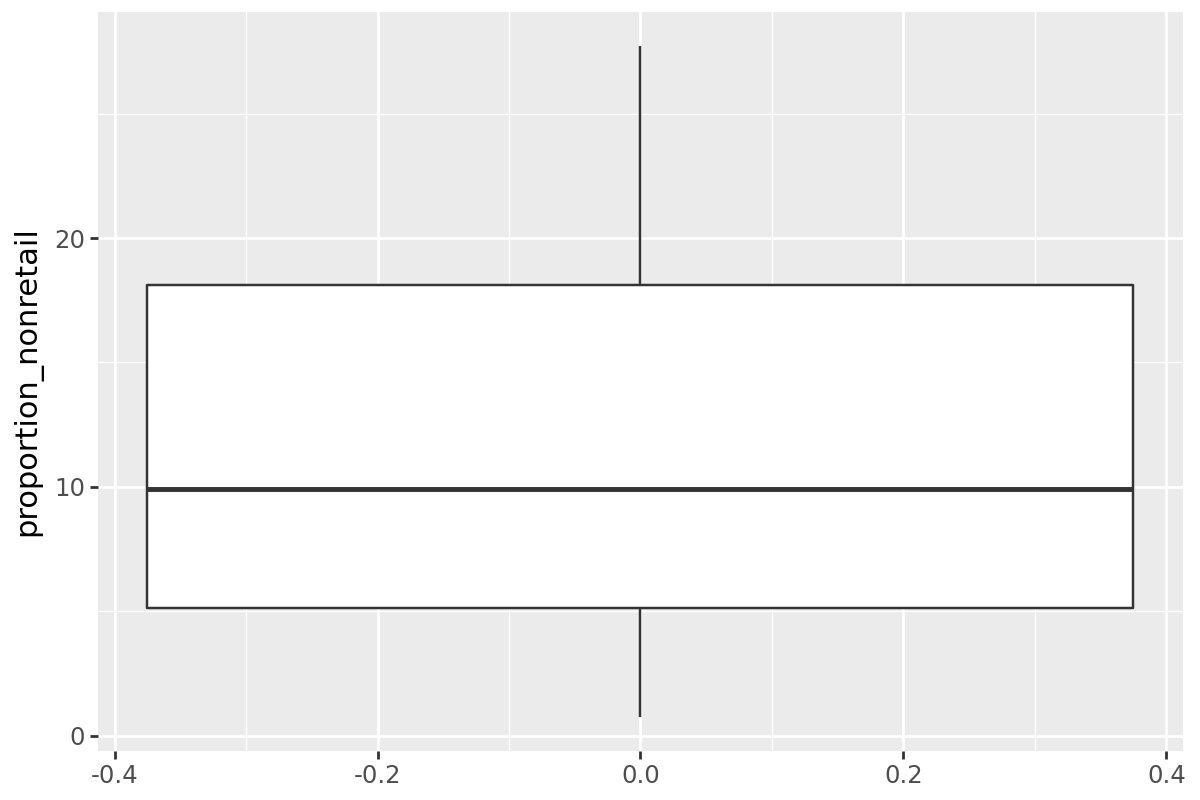

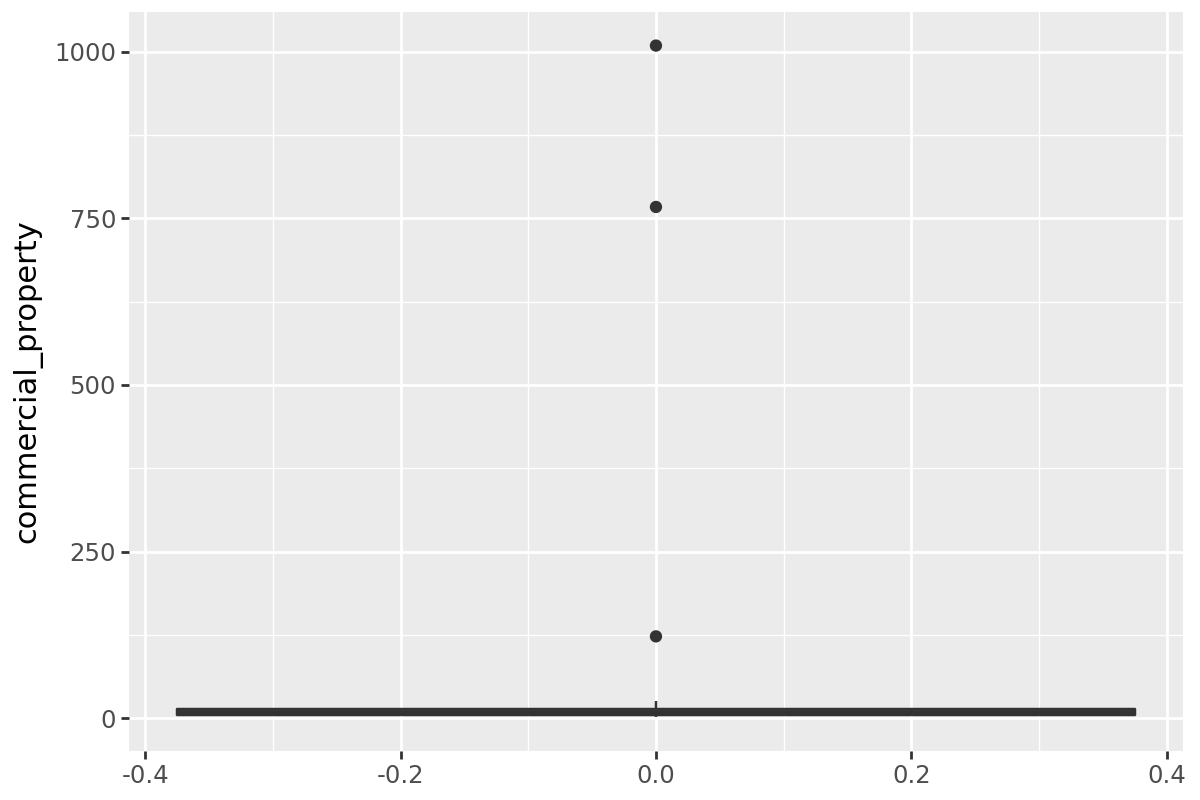

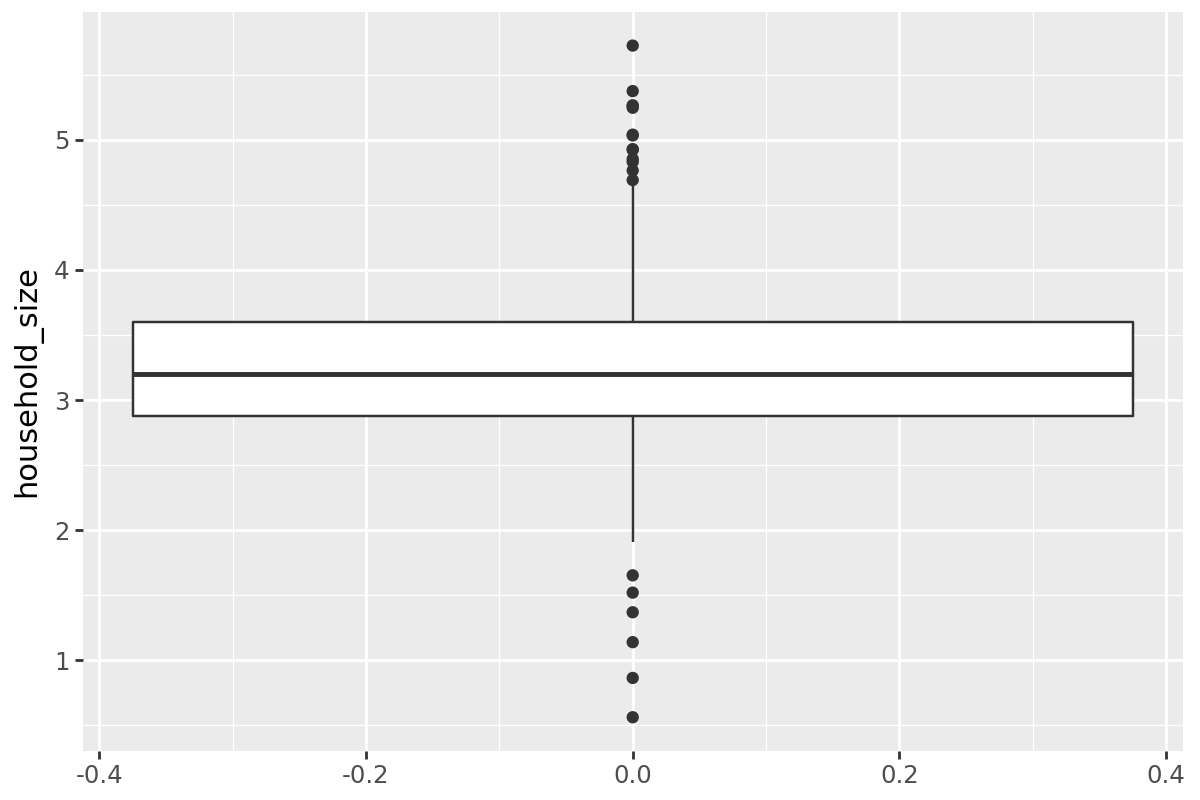

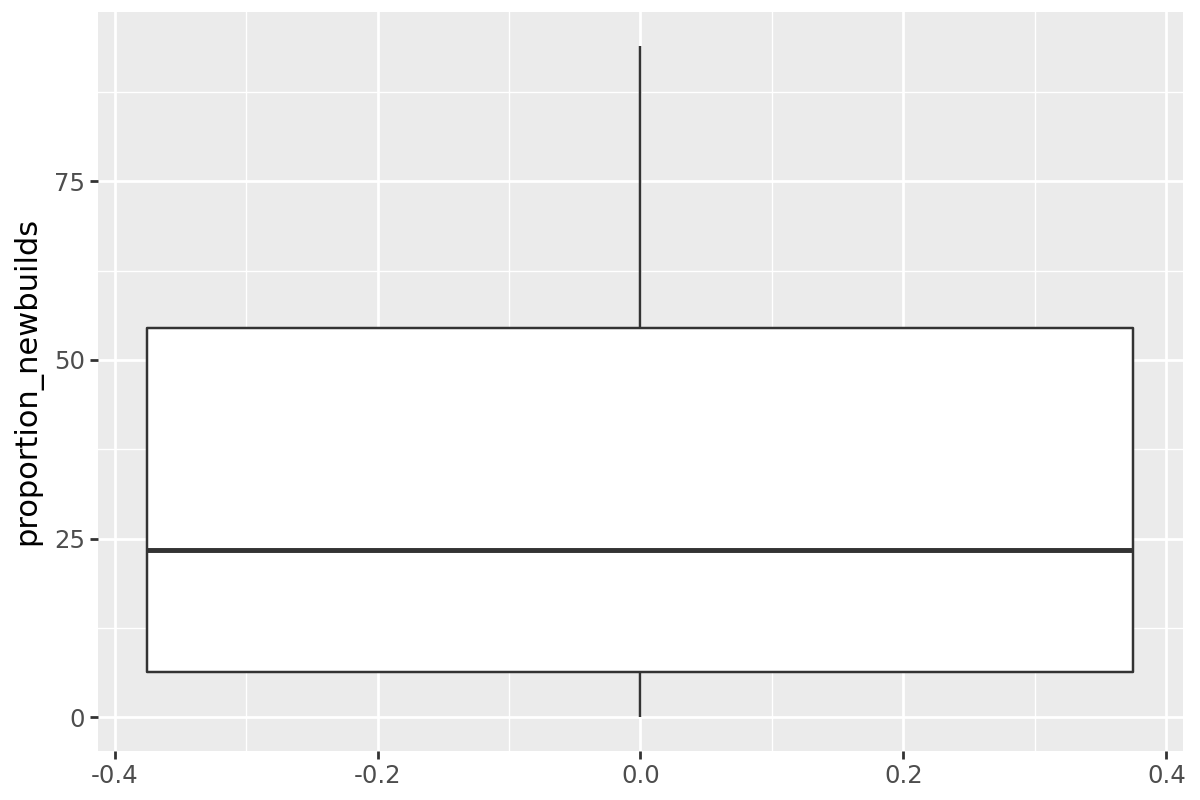

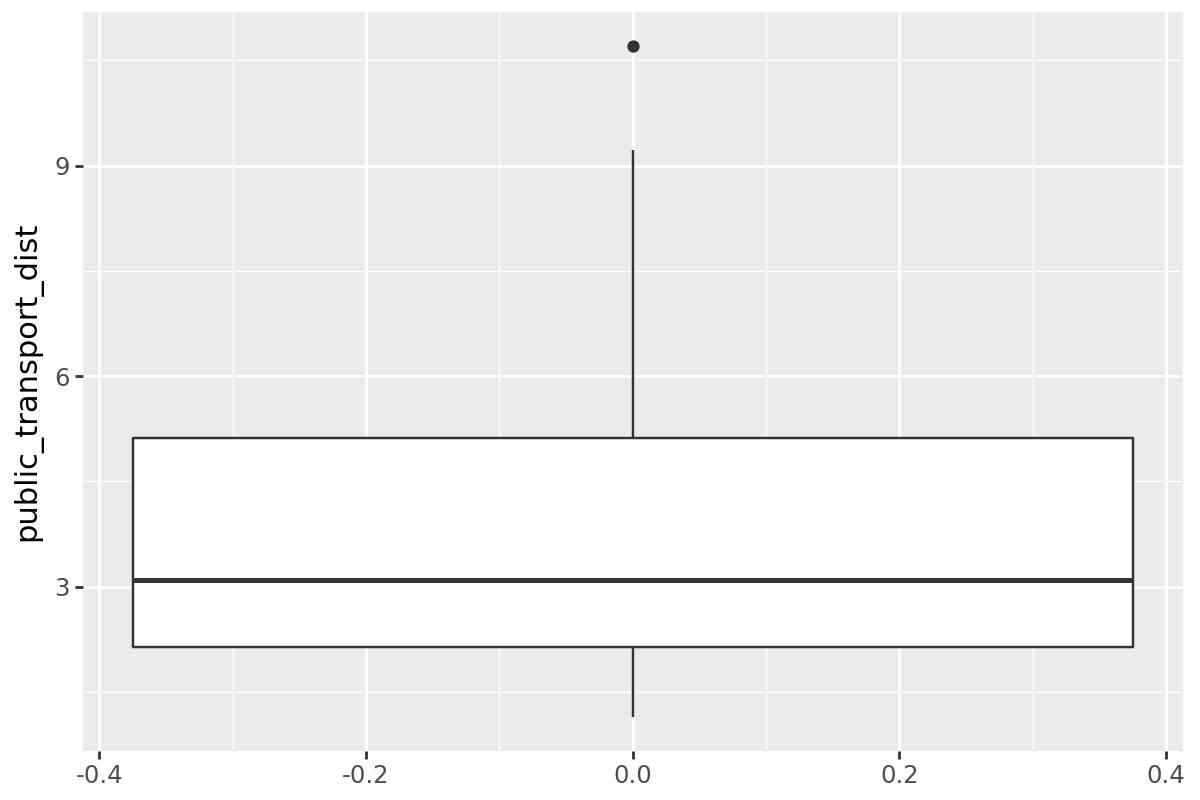

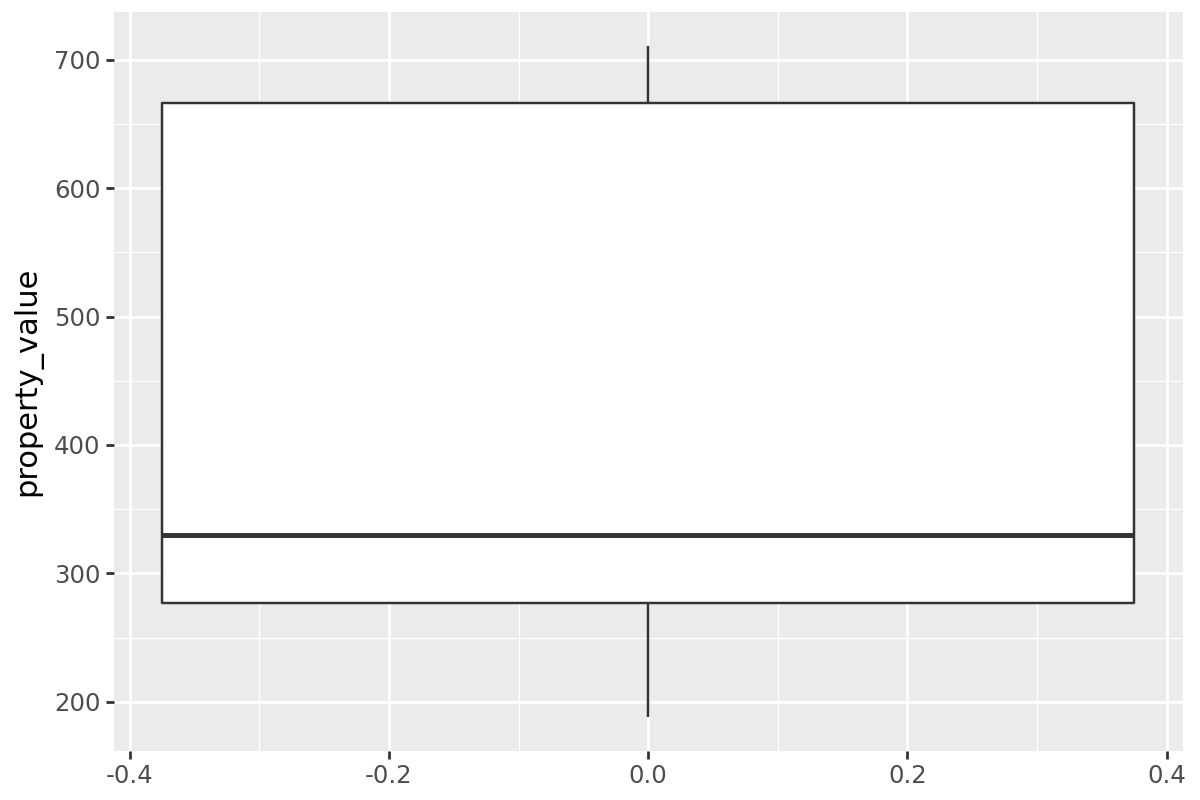

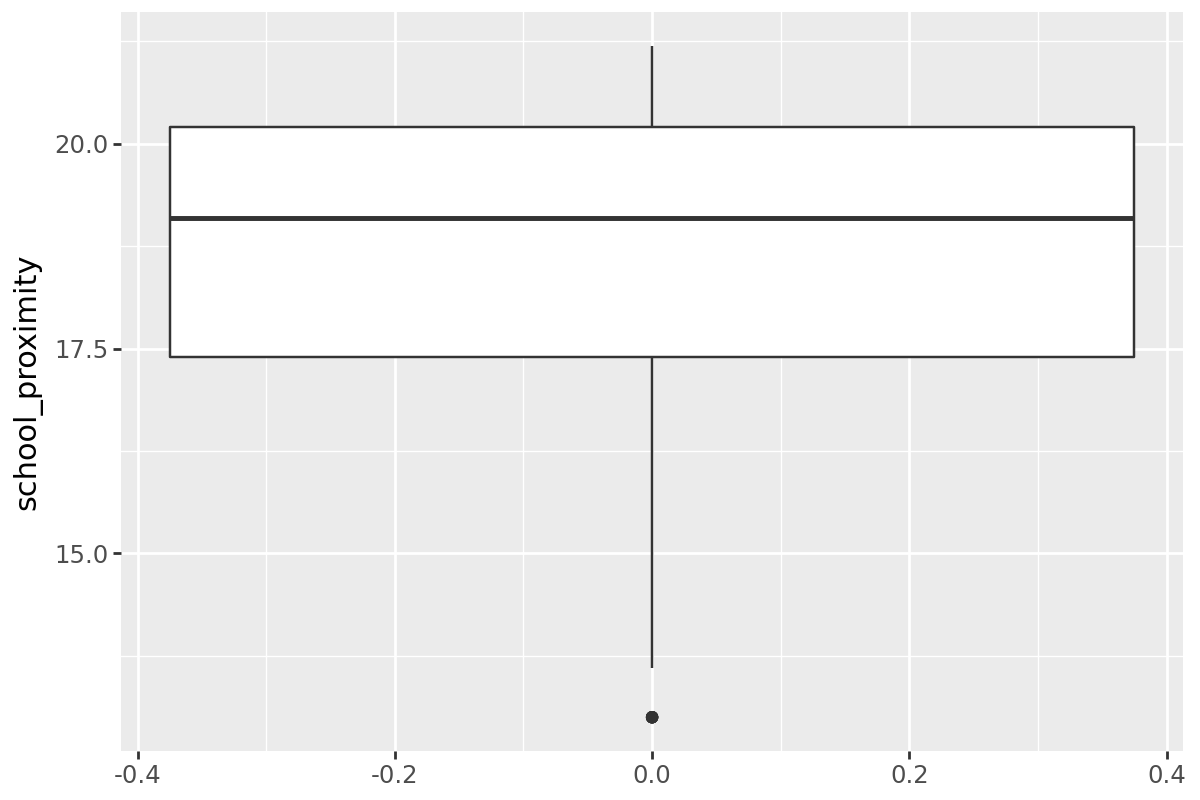

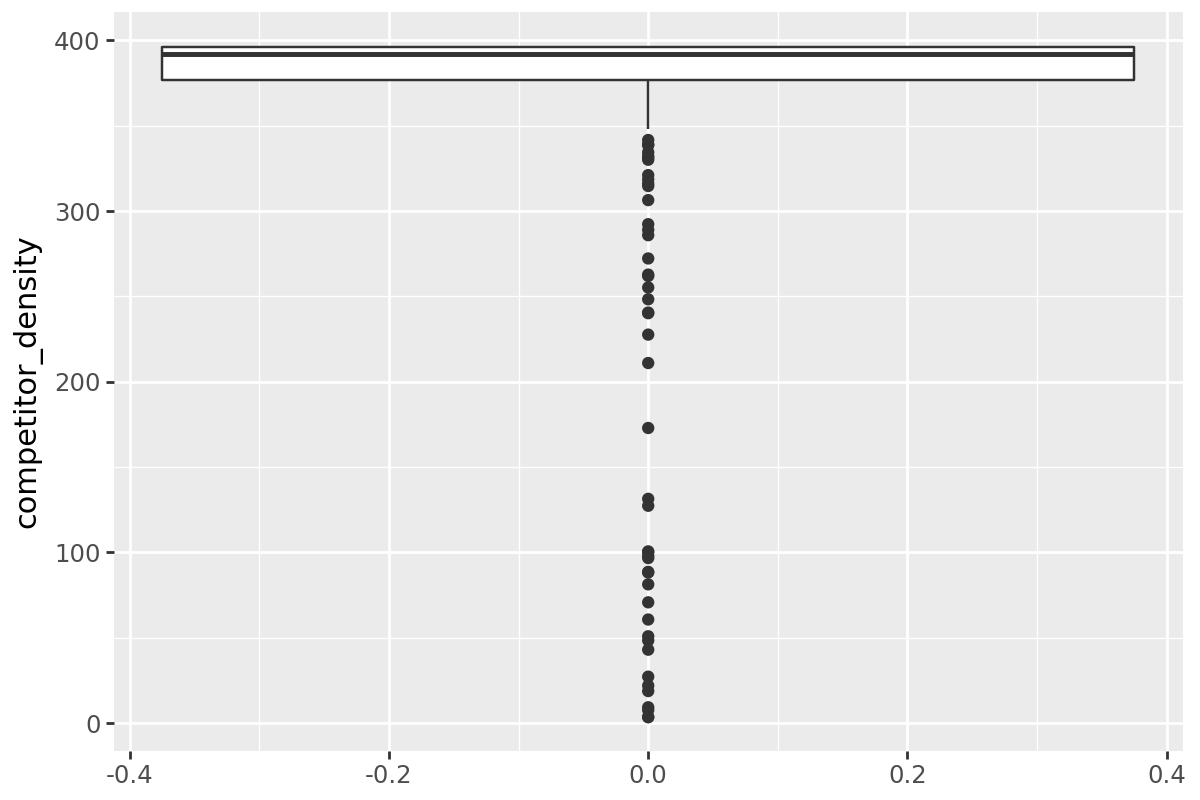

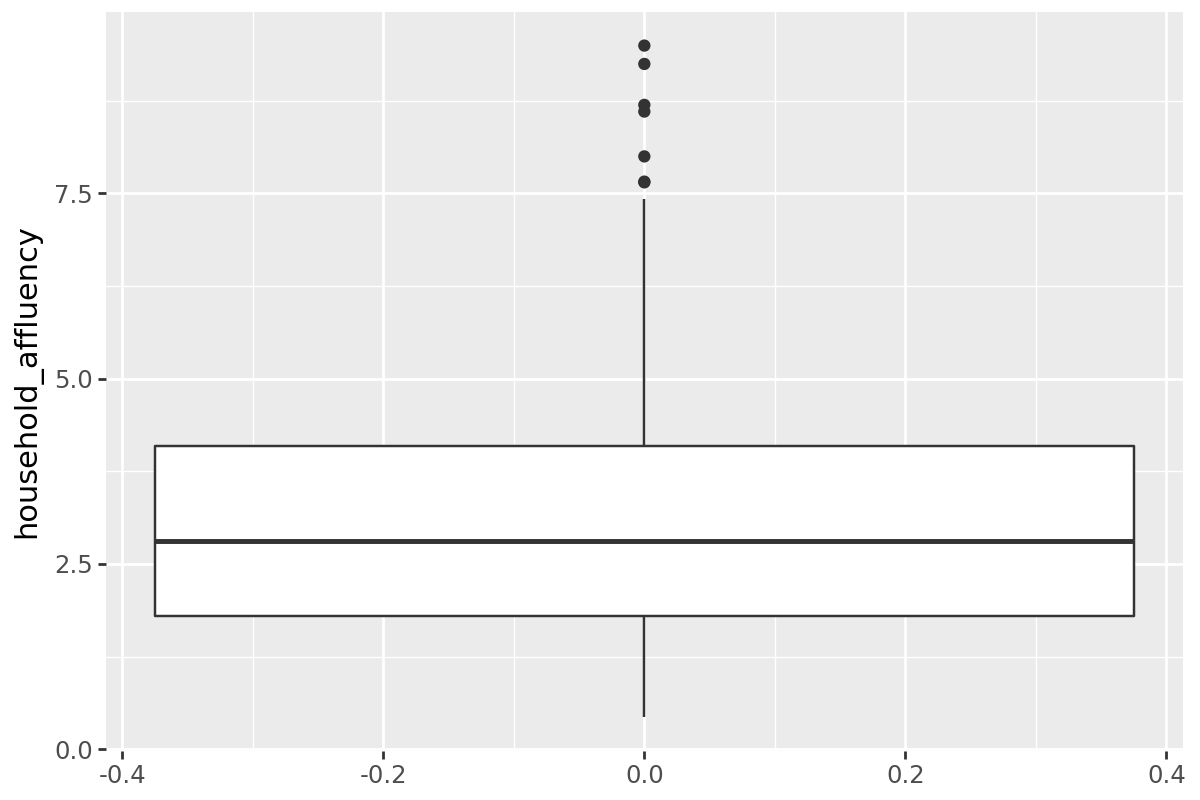

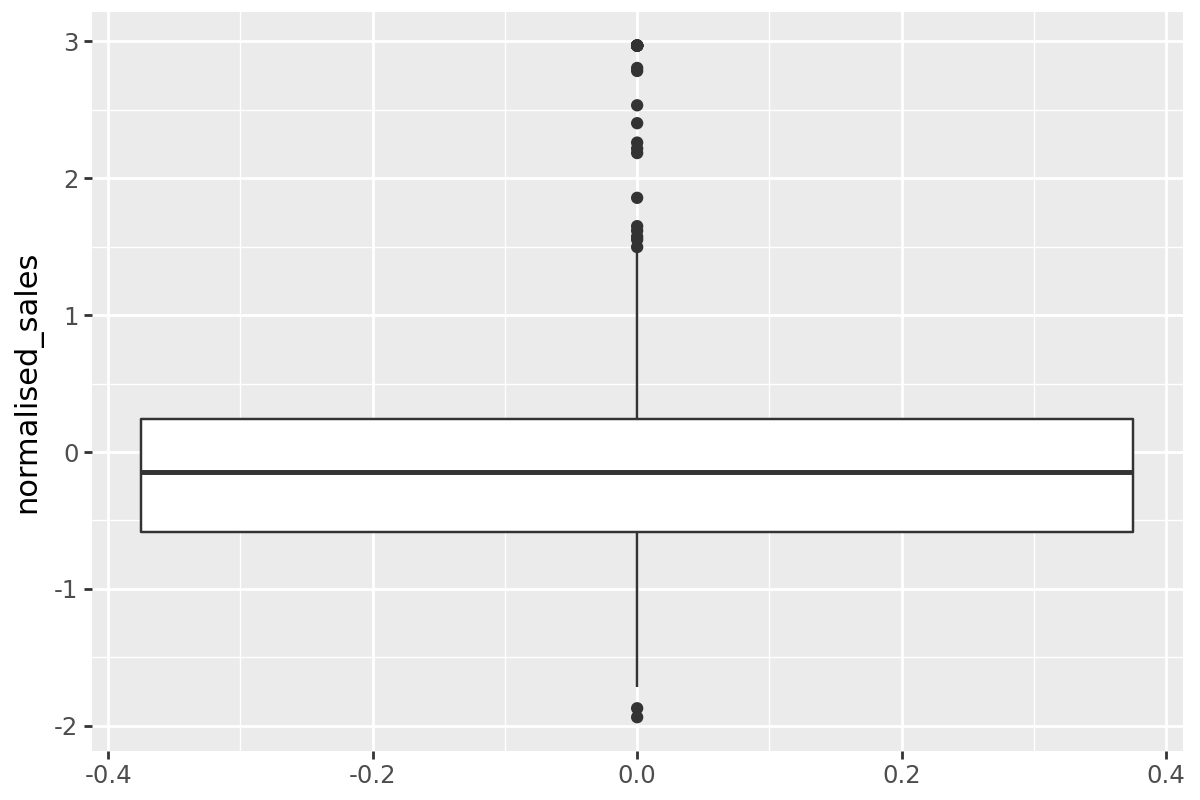

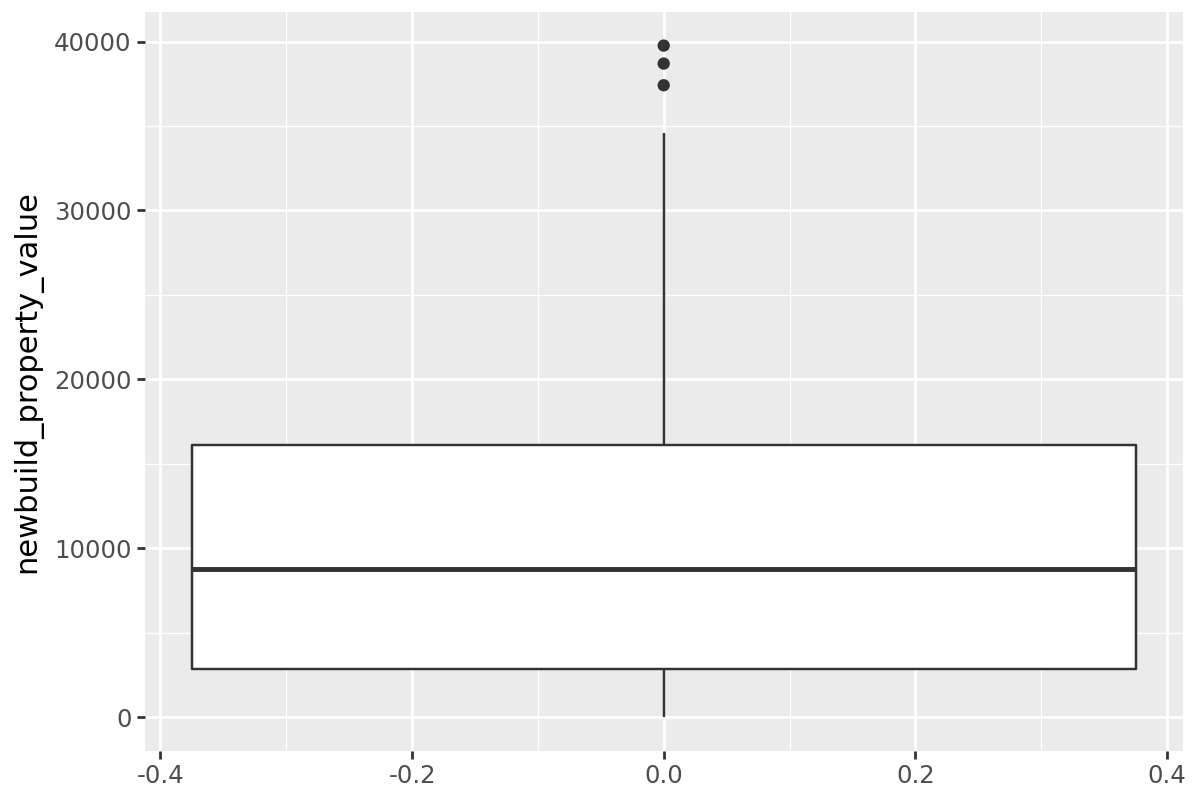

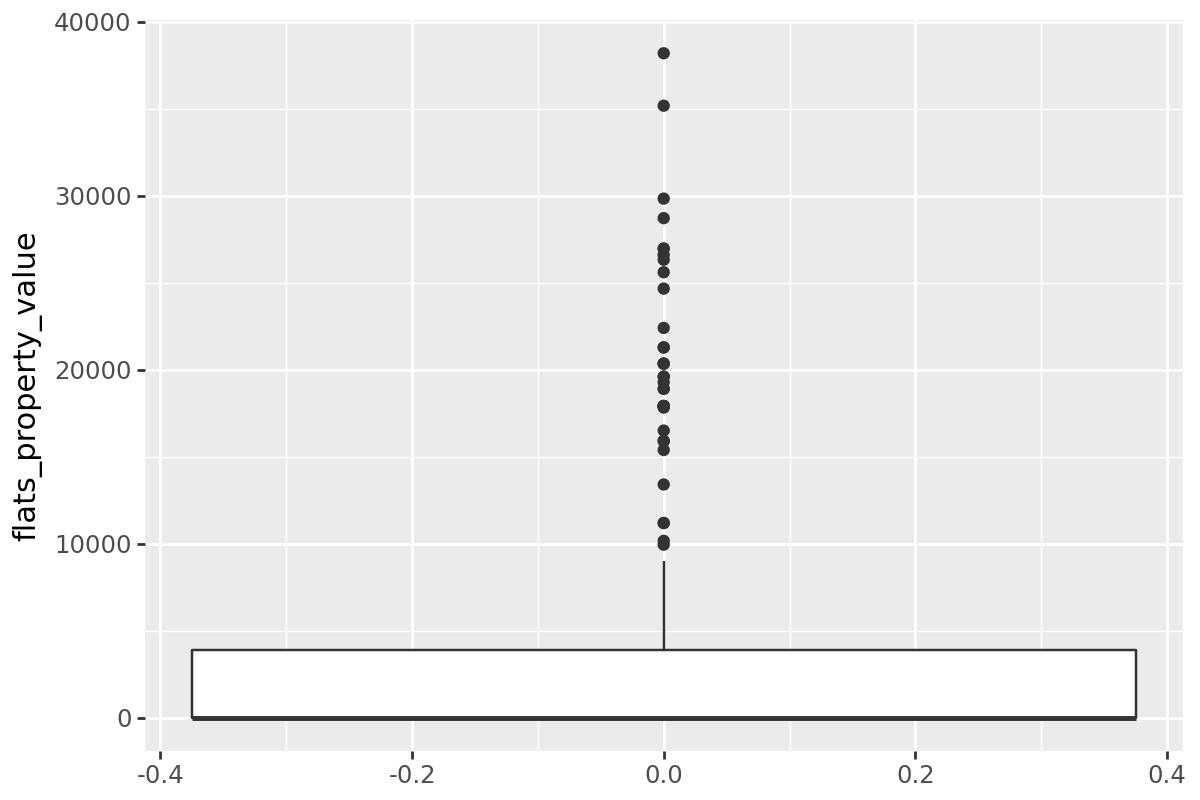

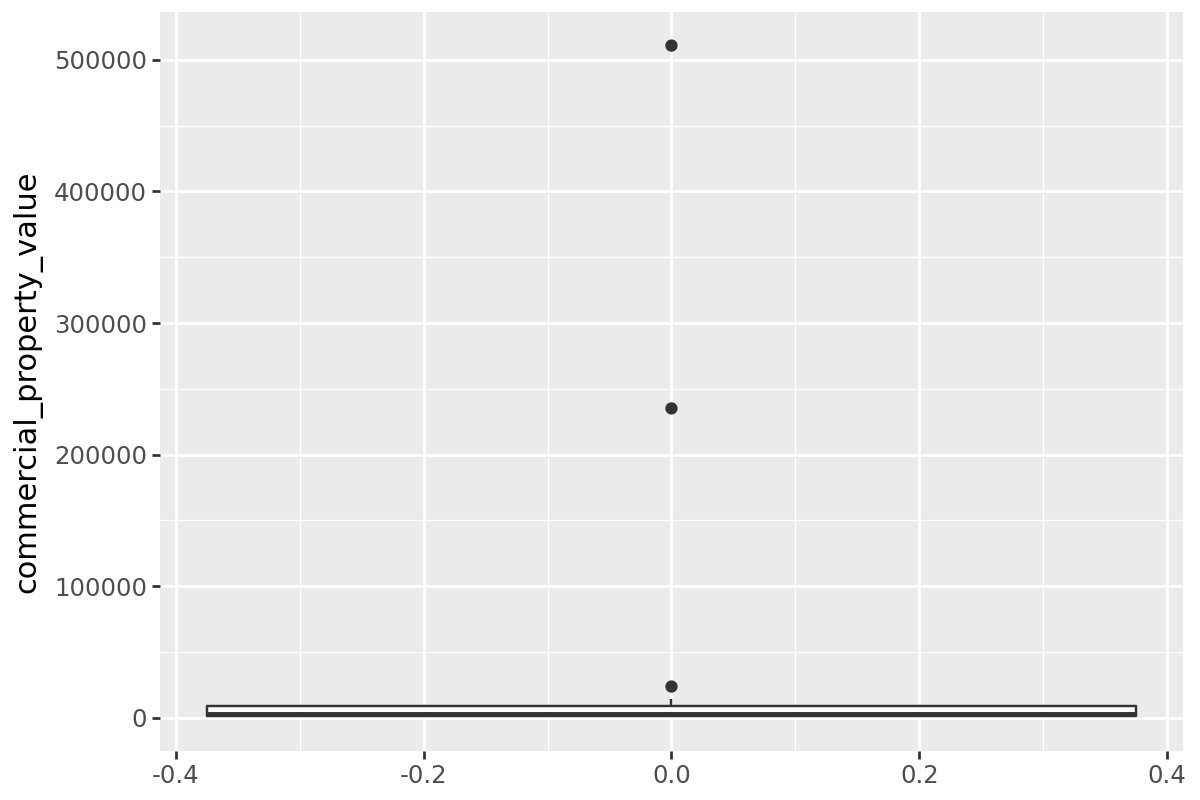

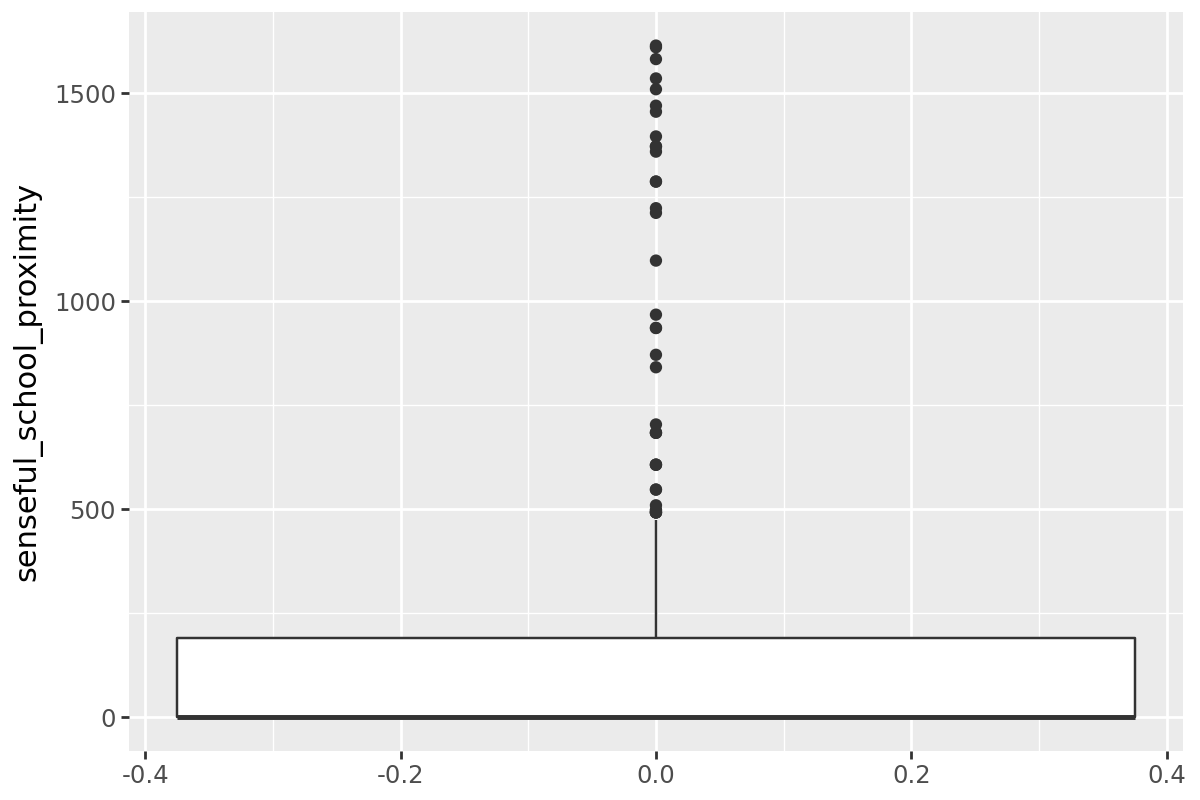

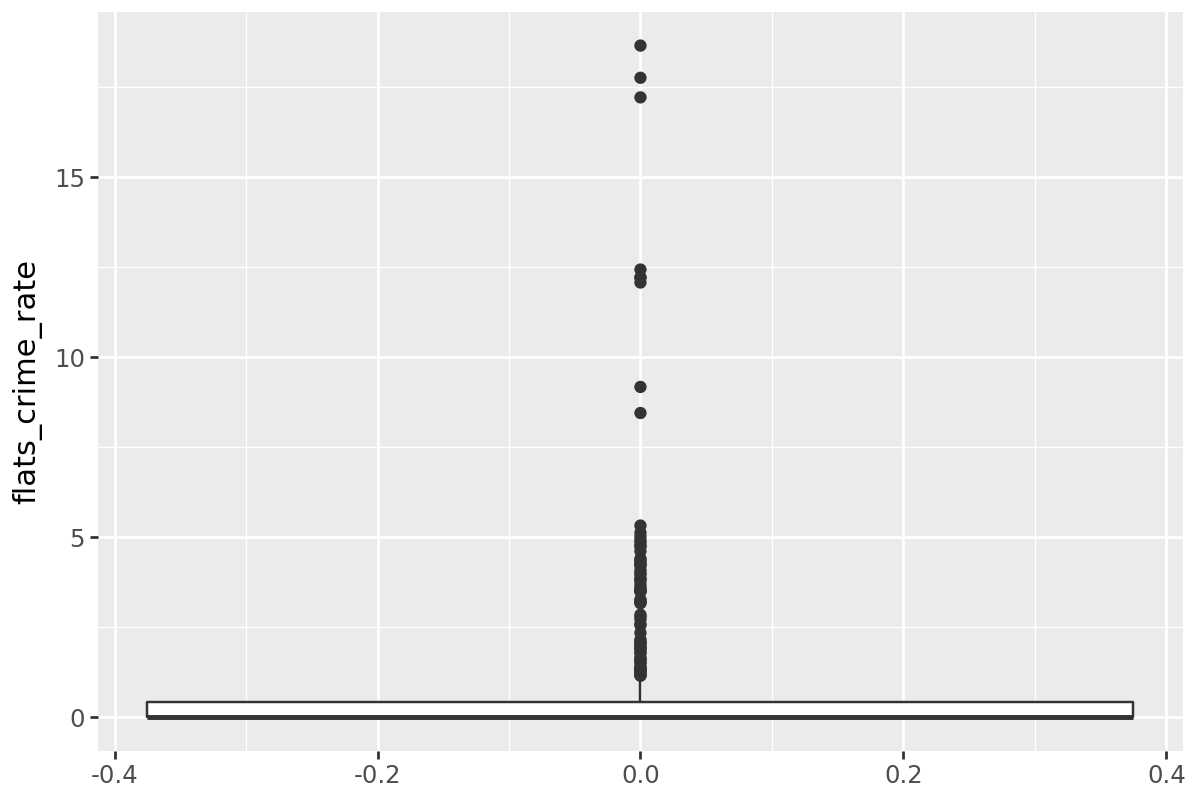

In [78]:
#Checking the distribution for numerical variables 
for var in numerical_columns:
    print(
        (
             p9.ggplot(raw_data)
            +p9.aes(y=var)
            +p9.geom_boxplot()
            +p9.theme(figure_size=(6,4))
            # + p9.facet_wrap("~normalised_sales", scales='free_y')
        )
    )

* Outlier needs to be handled for commercial_property, household_size, competitor_density

### Distribution check

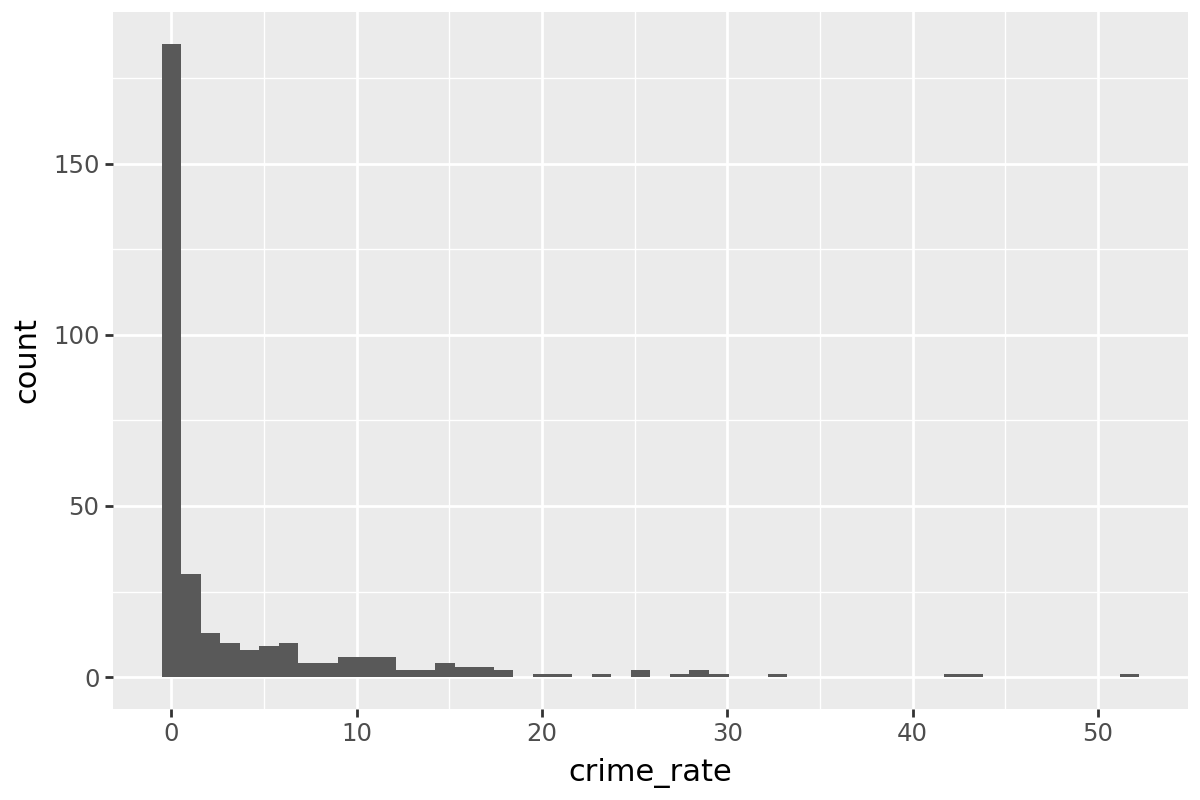

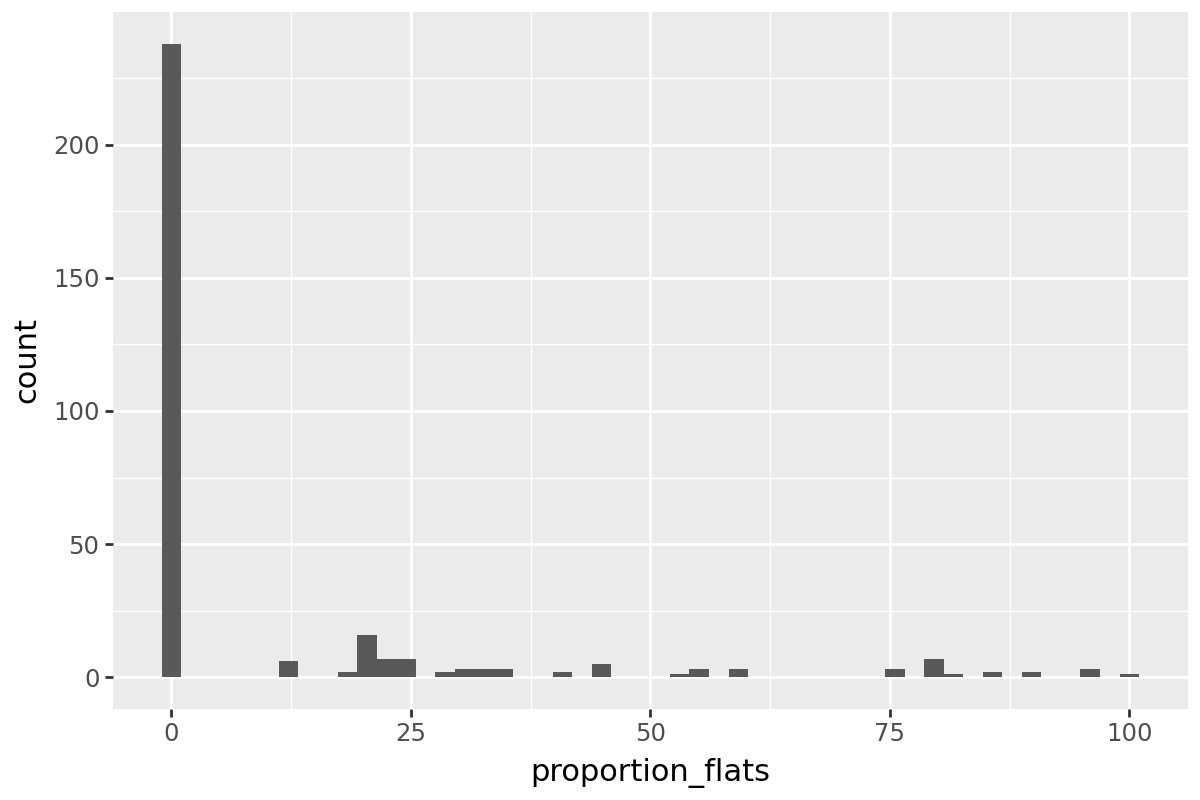

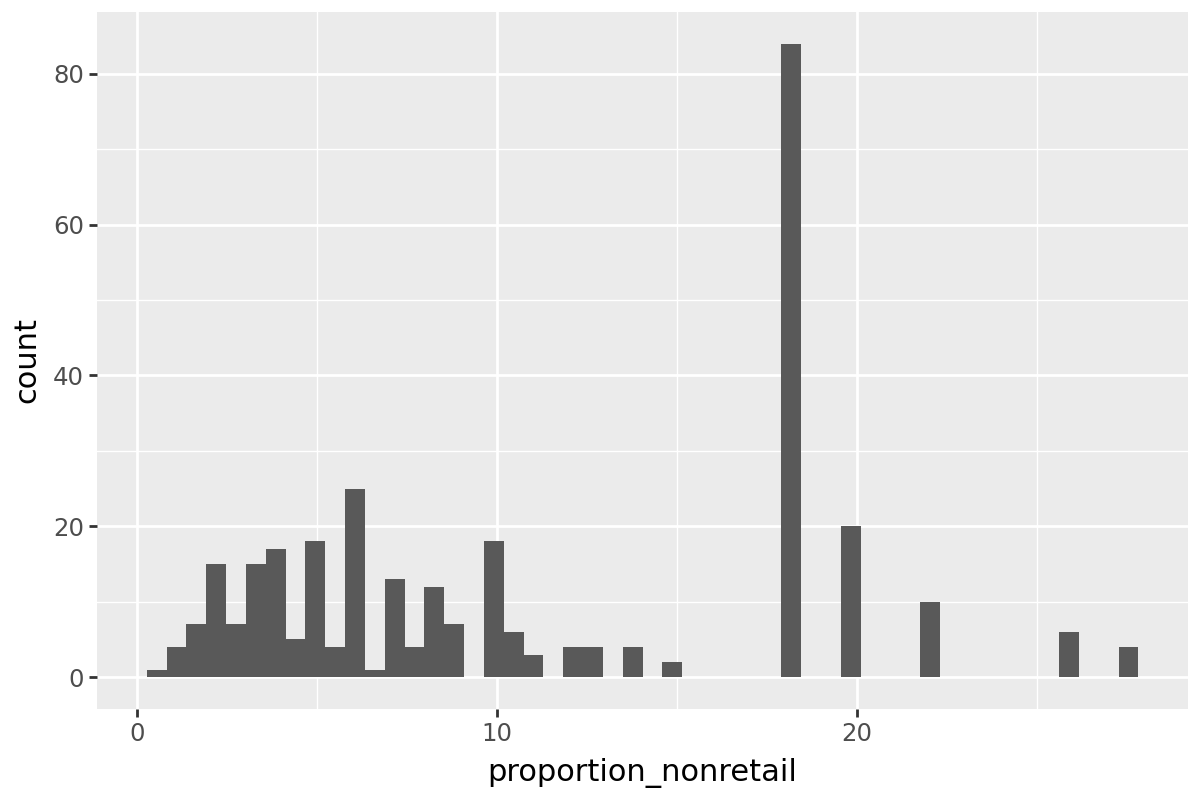

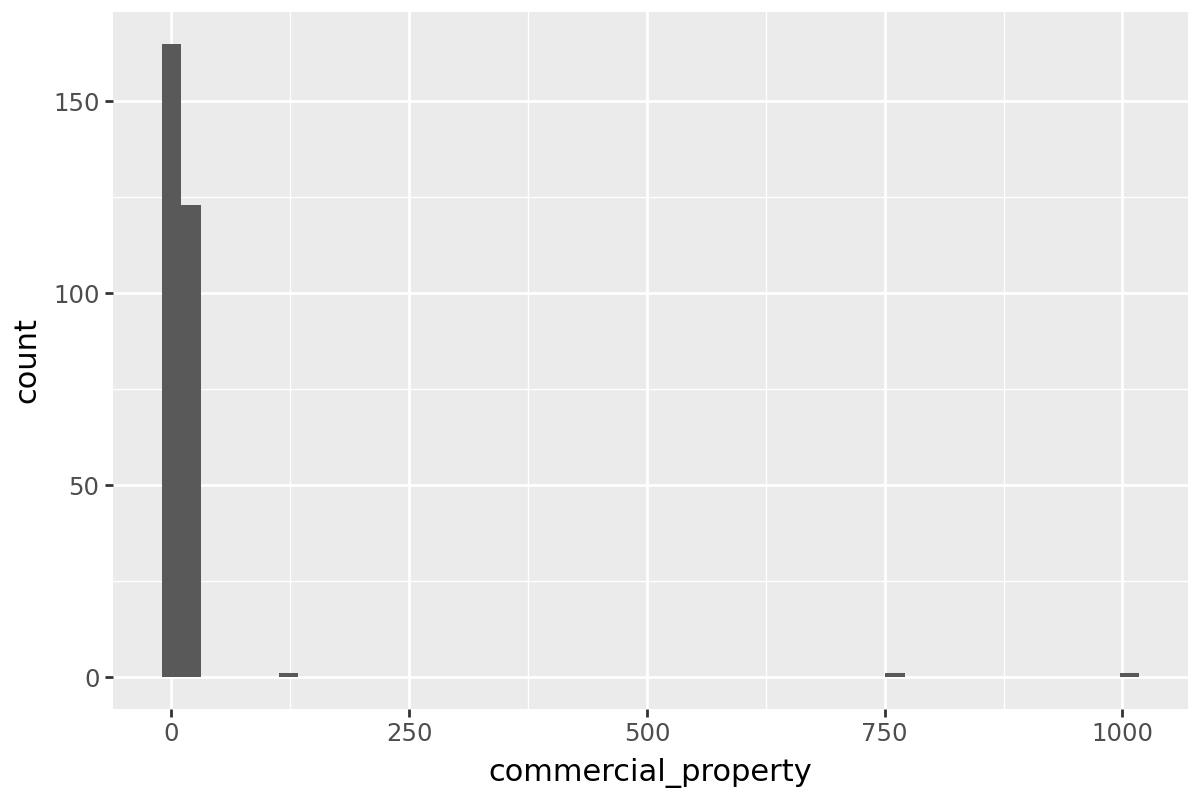

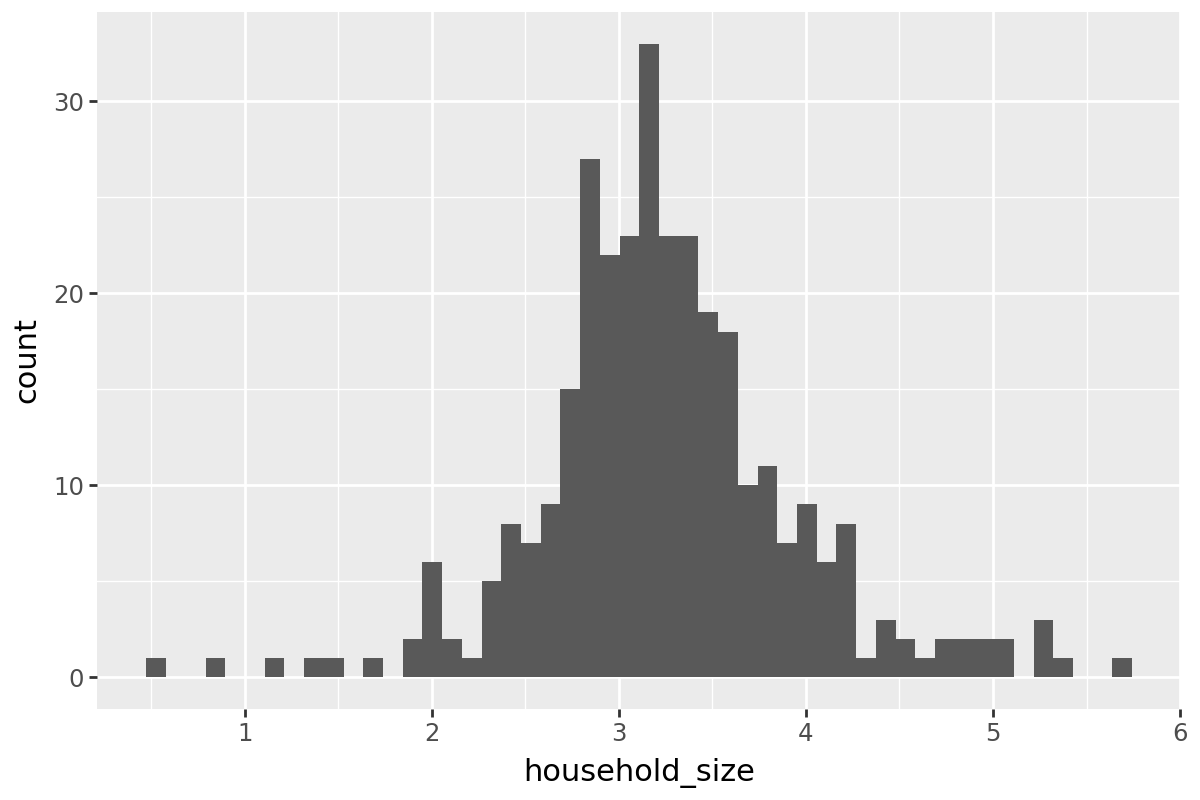

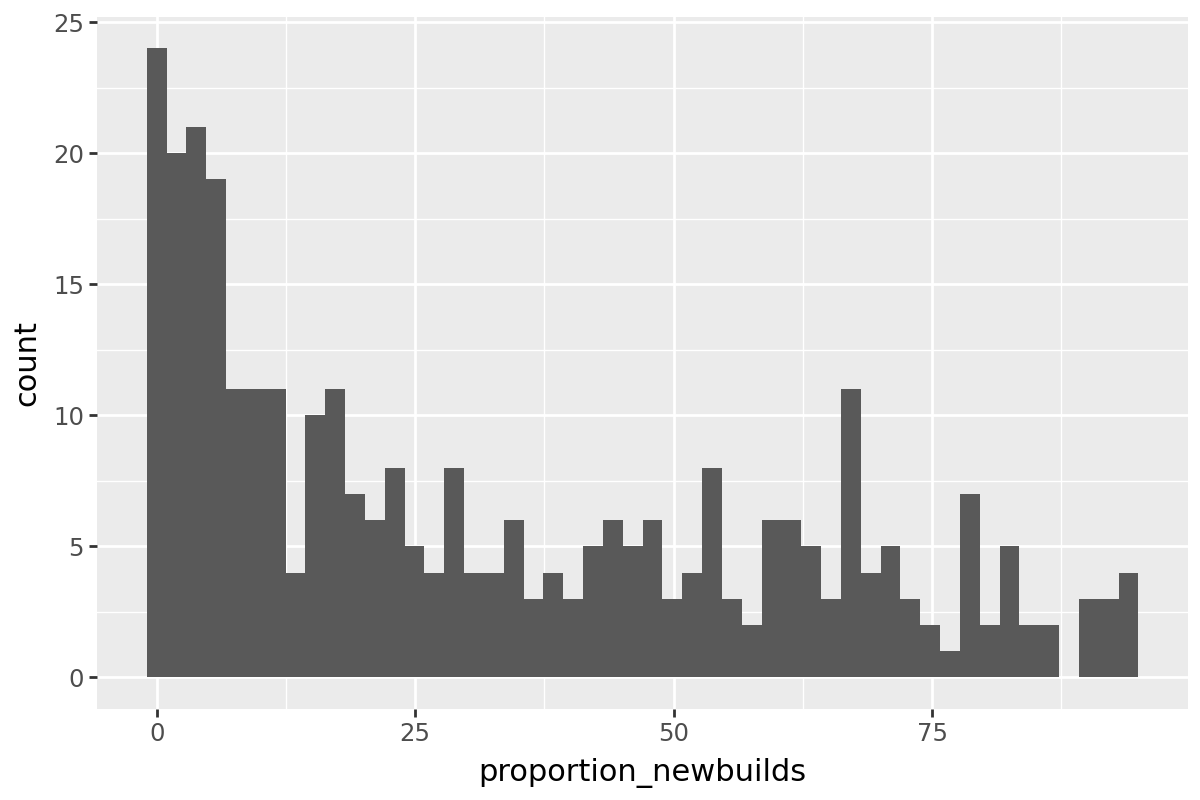

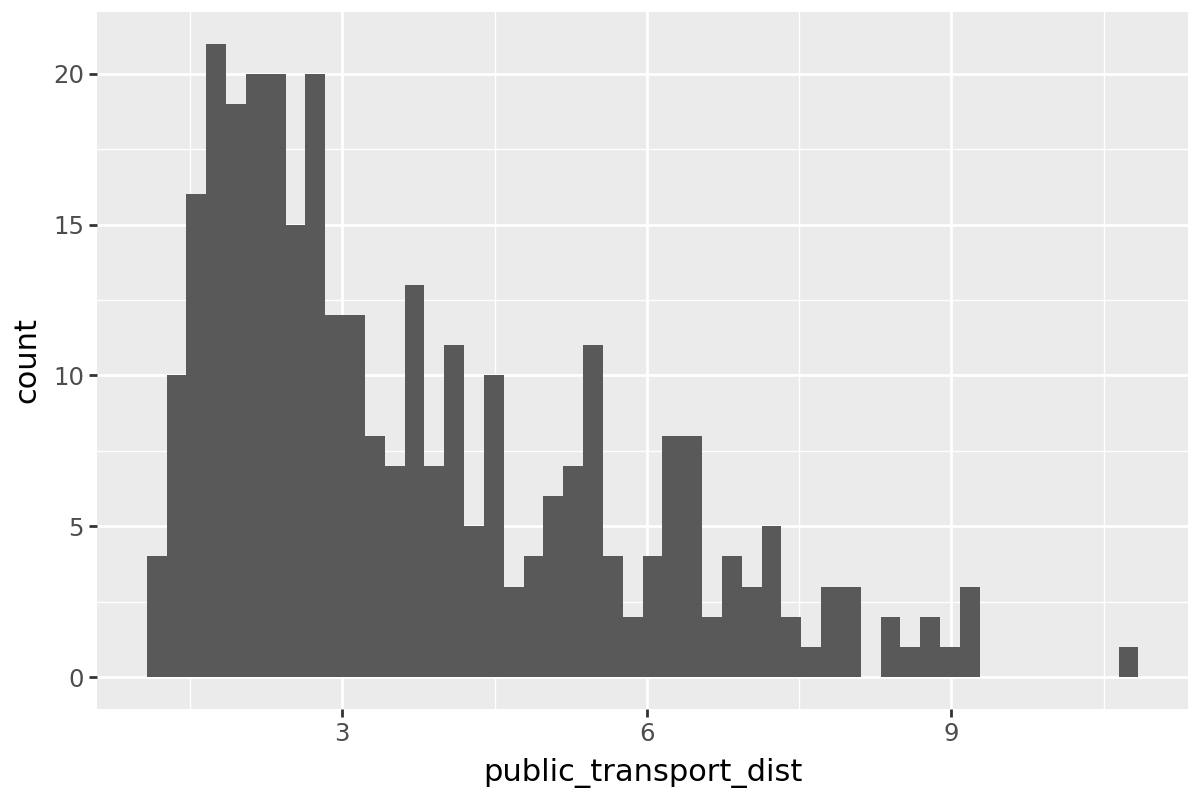

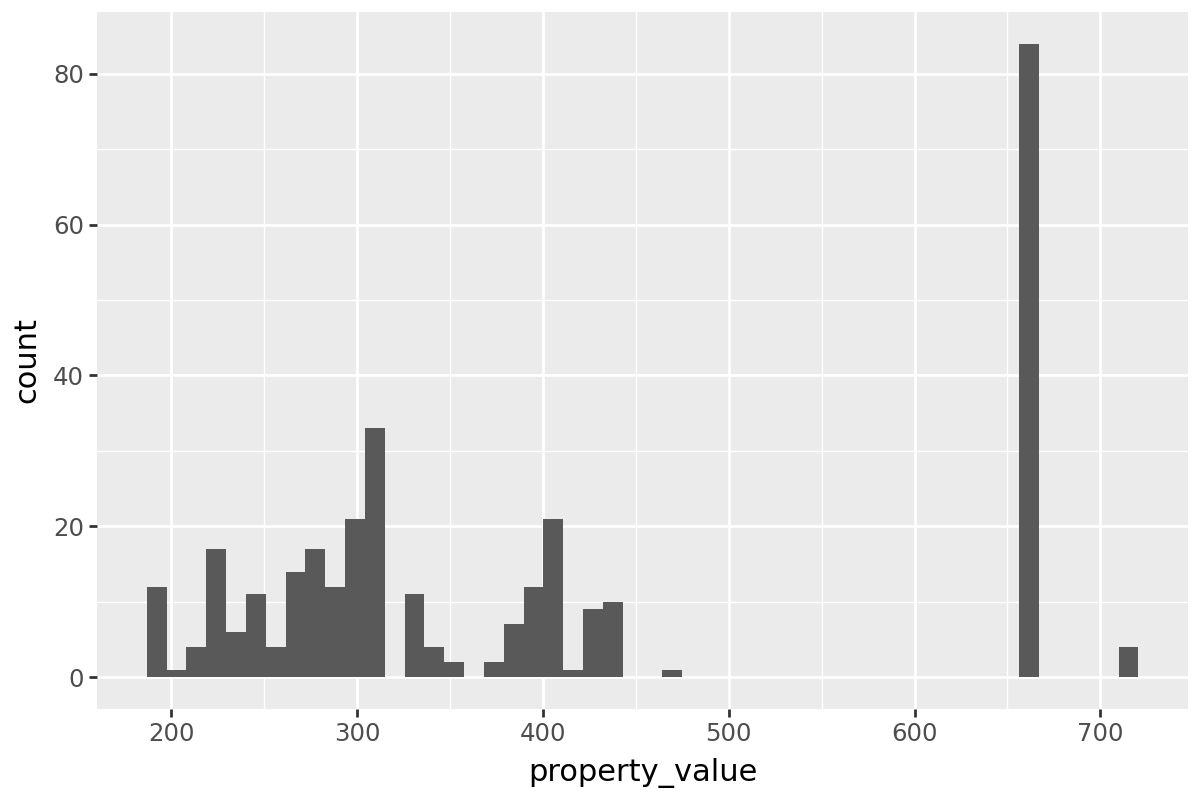

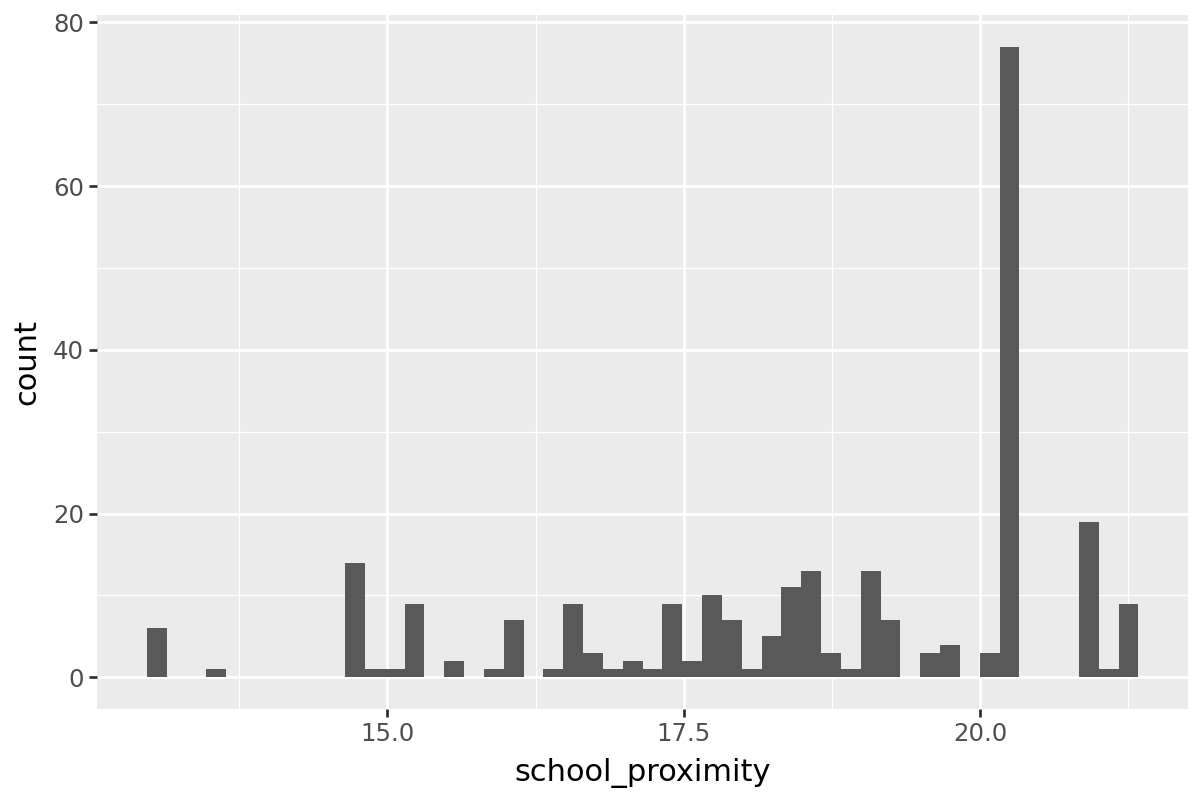

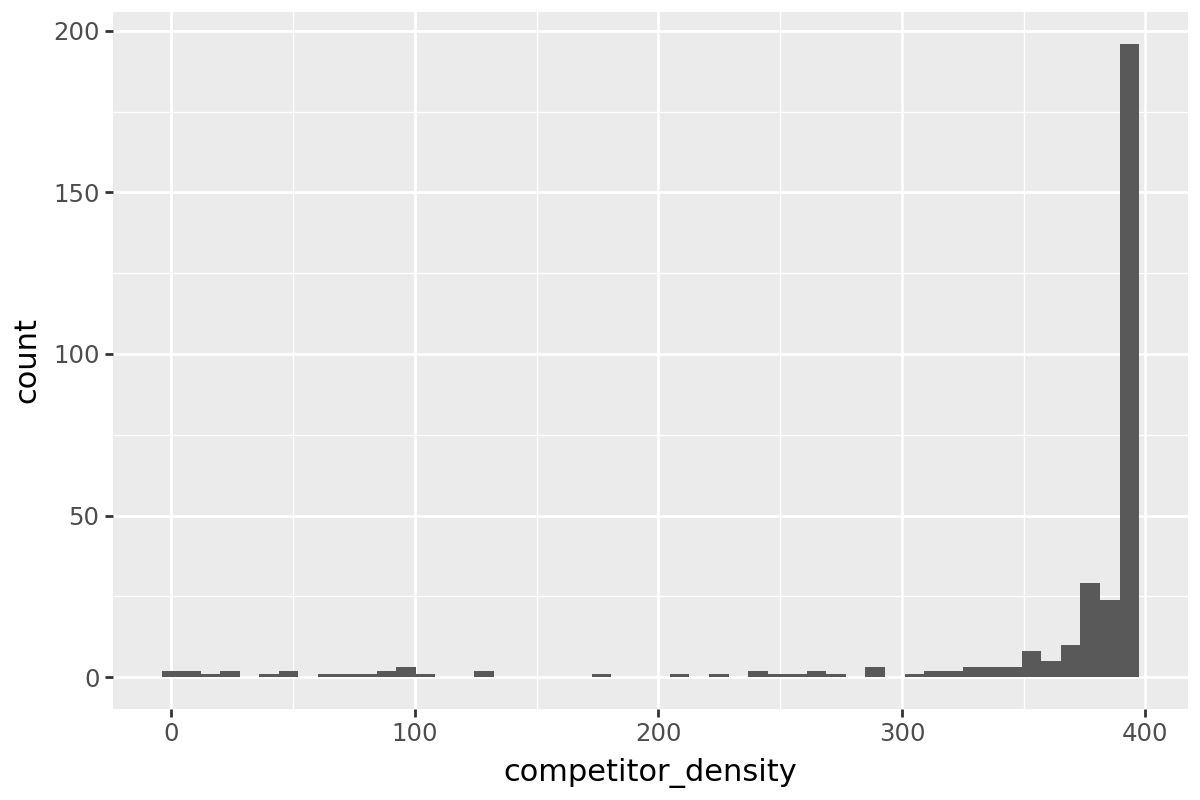

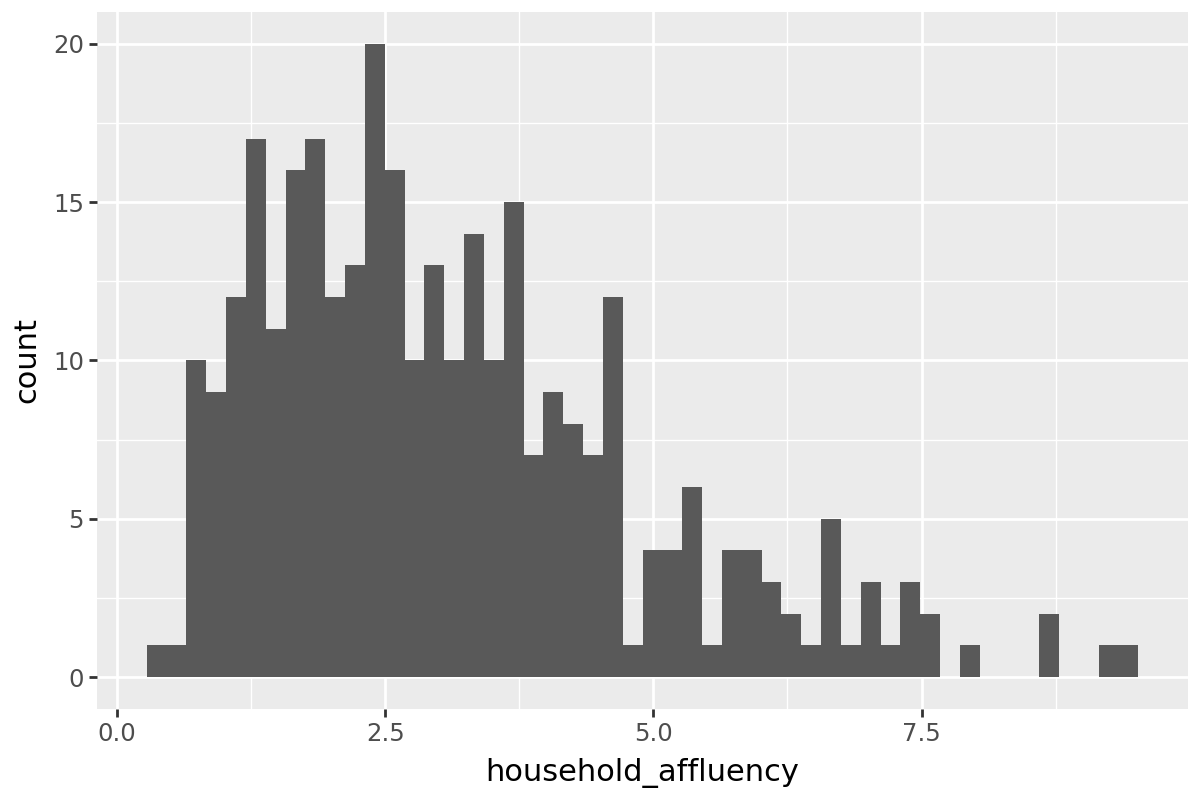

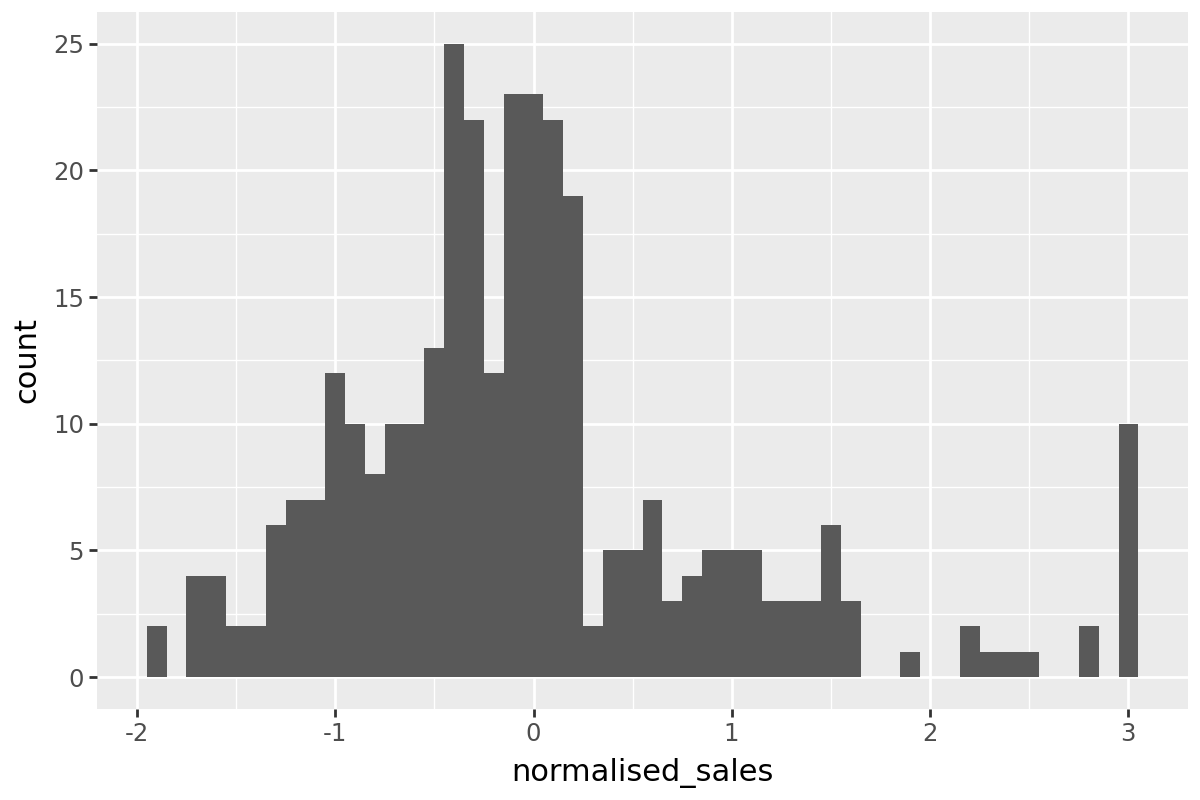

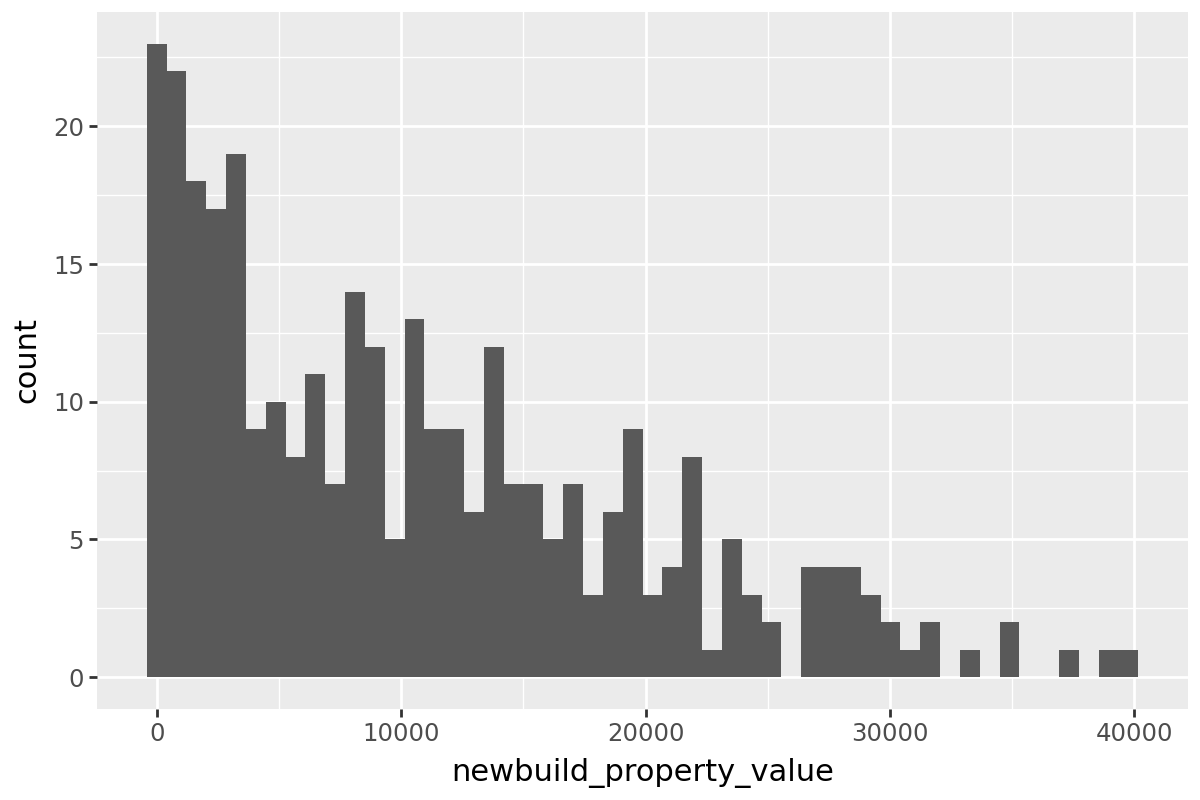

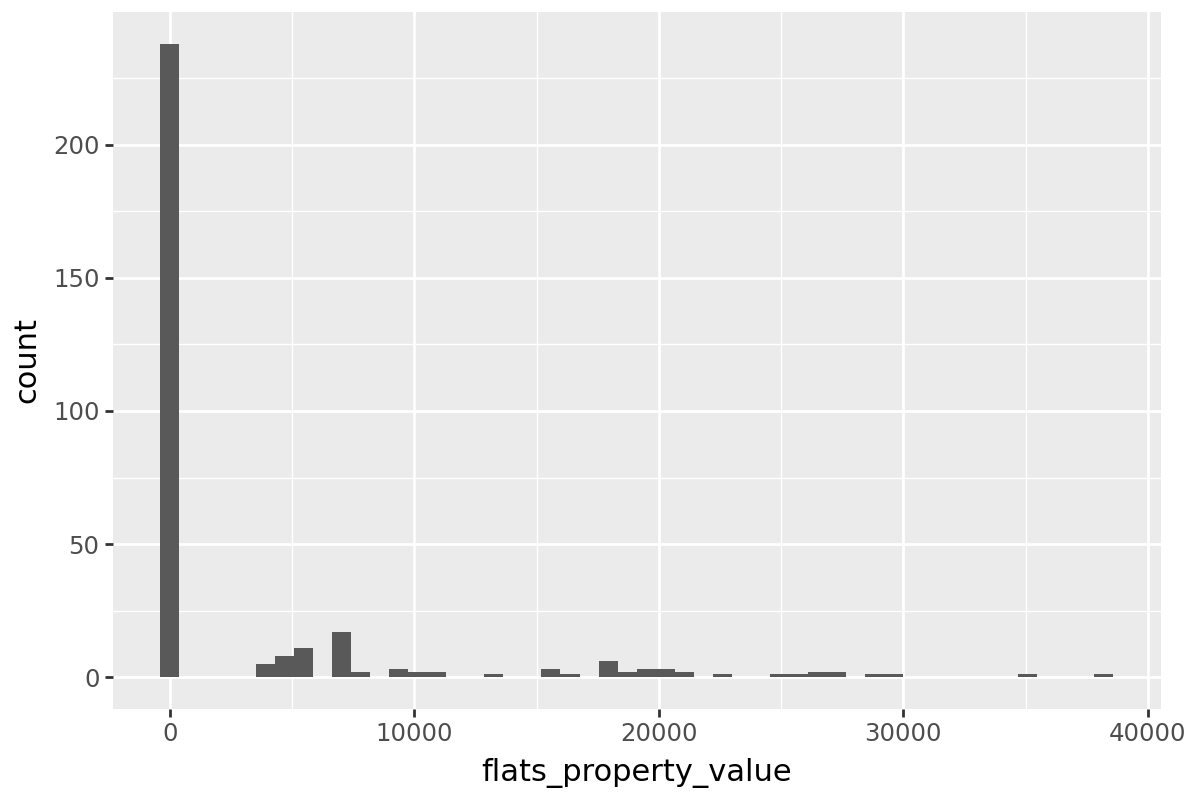

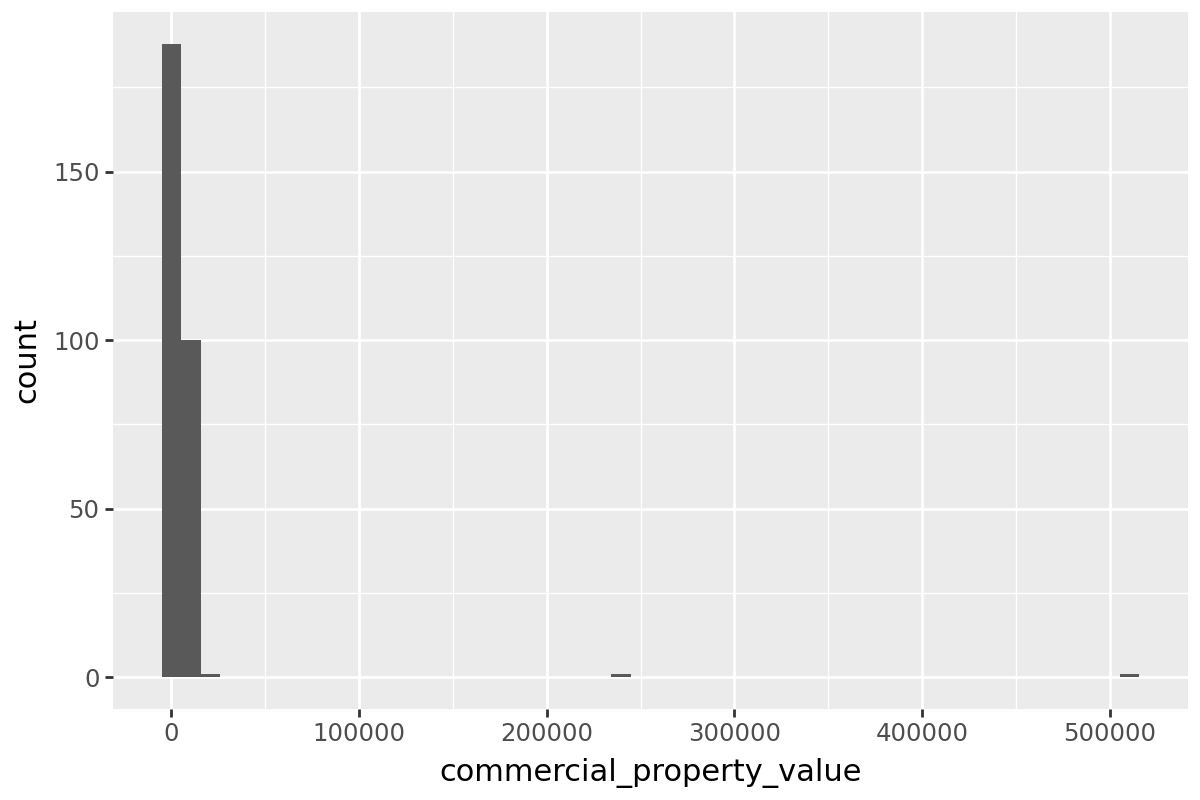

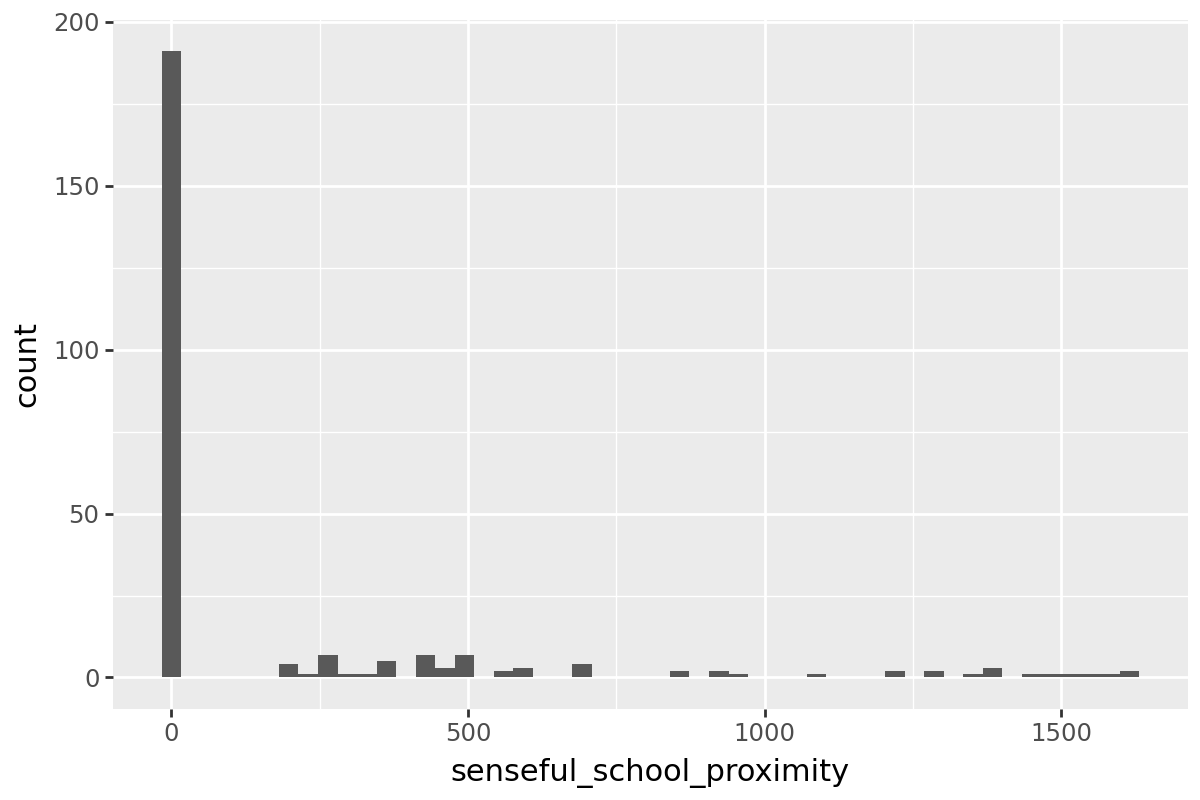

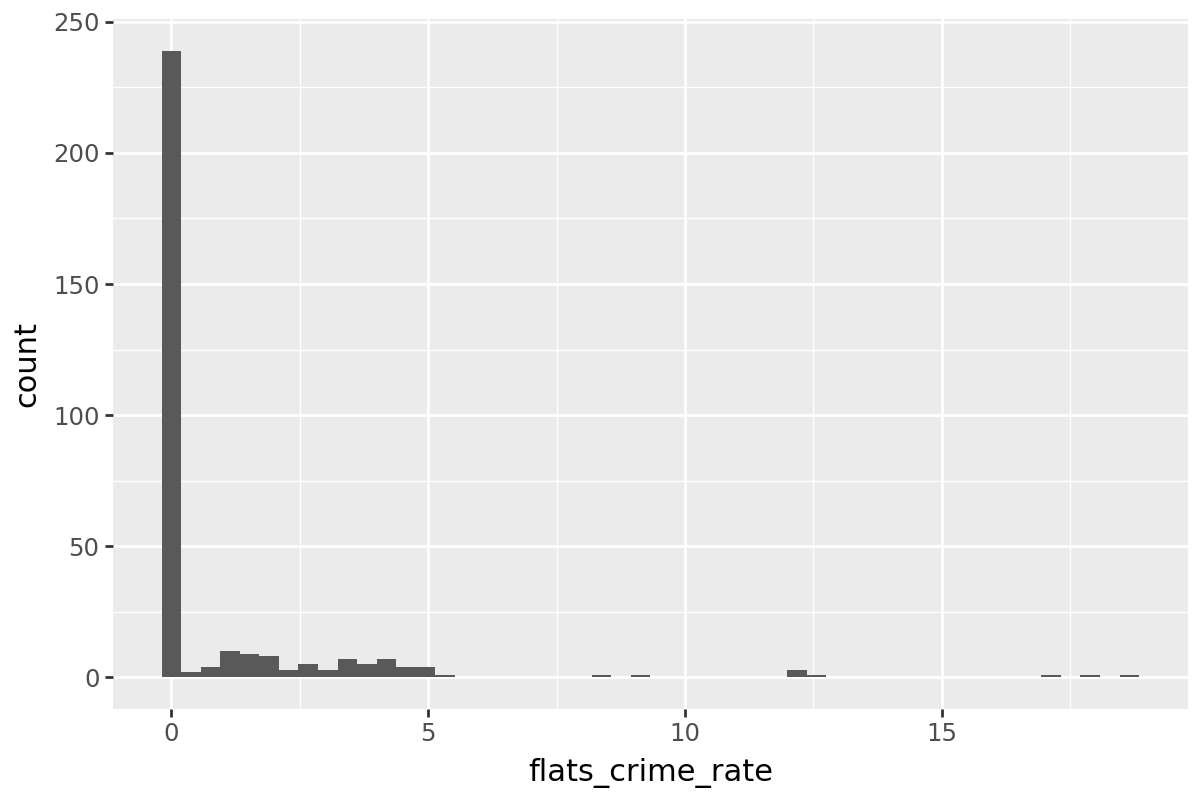

In [79]:
#Checking the distribution for numerical variables 
for var in numerical_columns:
    print(
        (
             p9.ggplot(raw_data)
            +p9.aes(x=var)
            +p9.geom_bar(stat='bin', bins=50)
            +p9.theme(figure_size=(6,4))
            # + p9.facet_wrap("~normalised_sales", scales='free_y')
        )
    )

### Notes after univariate analysis:

1. No visible data seen for competitor_density, public_transport_dist, crime_rate
2. Possible outlier in commercical_property column
3. Outlier needs to be handled for commercial_property, household_size, competitor_density

### Bivariate - correlation with target variable

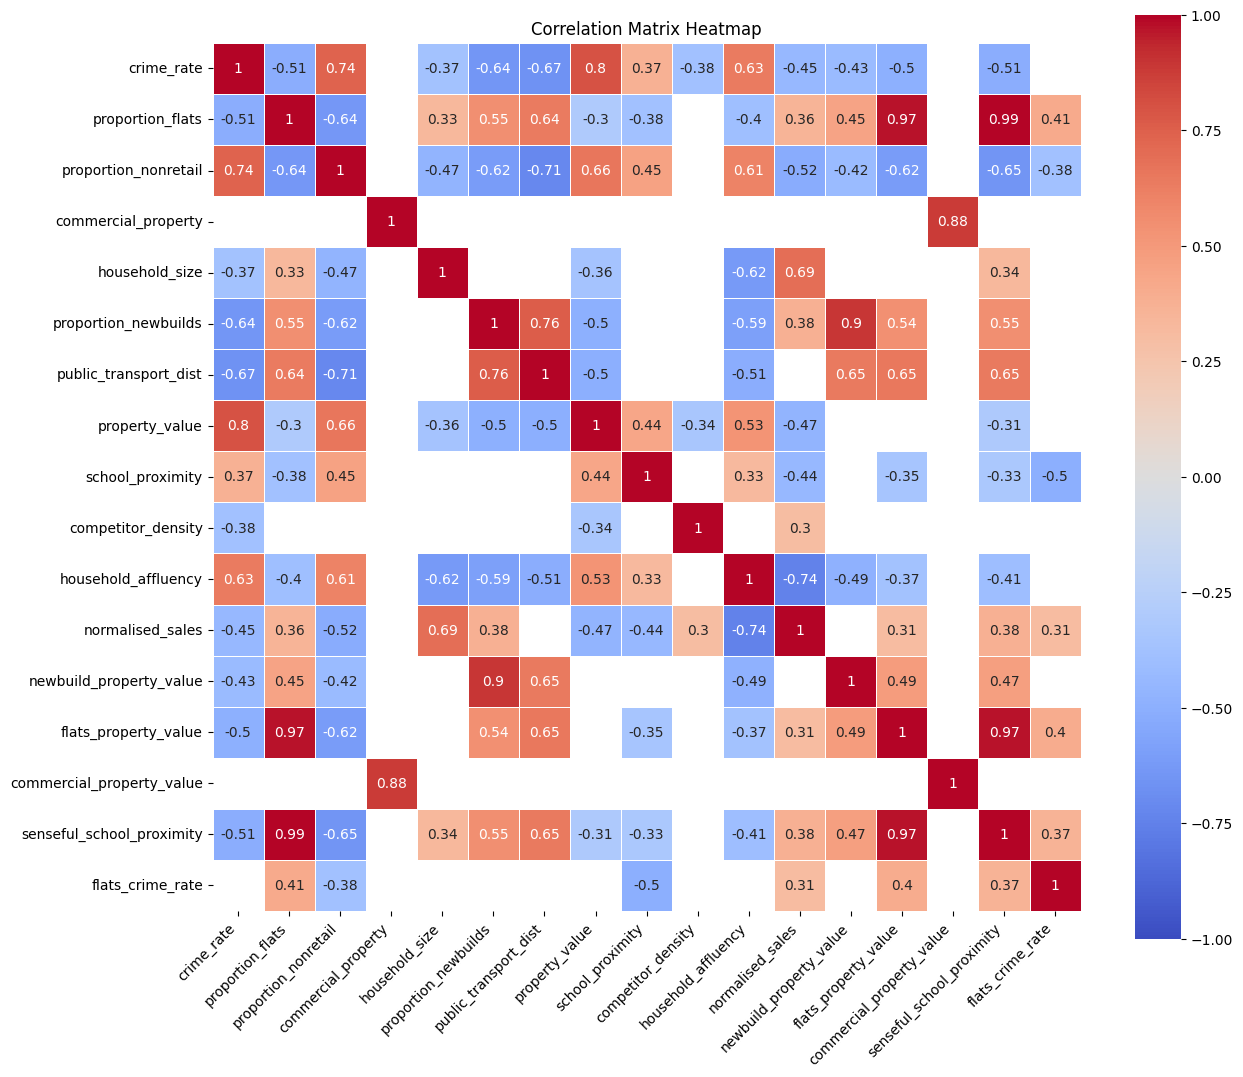

In [154]:
#Correlation between continuous variables
corrThreshold = 0.3
correlation_matrix = raw_data[numerical_columns].corr() 
correlation_matrix = correlation_matrix[(correlation_matrix> corrThreshold) | (correlation_matrix < (-1 *corrThreshold) )]

# Initialize a matplotlib figure
plt.figure(figsize=(14, 12))

# Create a heatmap
sns.heatmap(correlation_matrix, 
            annot=True,       # Annotate cells with correlation values
            cmap='coolwarm',  # Choose a color map
            vmin=-1, vmax=1,  # Set the range of values
            square=True,      # Display cells as squares
            linewidths=.5)    # Add lines between cells

# Customize the plot
plt.title('Correlation Matrix Heatmap')
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)  # Keep y-axis labels horizontal

# Show the plot
plt.show()

### Notes on correlation:
1. household_affluency has a strong inverse correlation with sales
2. household_size has high positive correlation with sales
3. There is a clear indication - Except the above 2 variables, others are not normally distributed. 

Lets focus on these variables first and increase their correlation by log transformation :  
1. proportion_nonretail,
2. crime_rate,
3. property_value,
4. school_proximity

In [19]:
raw_data.columns

Index(['location_id', 'crime_rate', 'proportion_flats', 'proportion_nonretail',
       'new_store', 'commercial_property', 'household_size',
       'proportion_newbuilds', 'public_transport_dist',
       'transport_availability', 'property_value', 'school_proximity',
       'competitor_density', 'household_affluency', 'normalised_sales',
       'county'],
      dtype='object')

In [83]:

columns_to_transform = ['proportion_nonretail','crime_rate','property_value','school_proximity','competitor_density']

# log transformation
raw_data[columns_to_transform] = raw_data[columns_to_transform].apply(np.log)

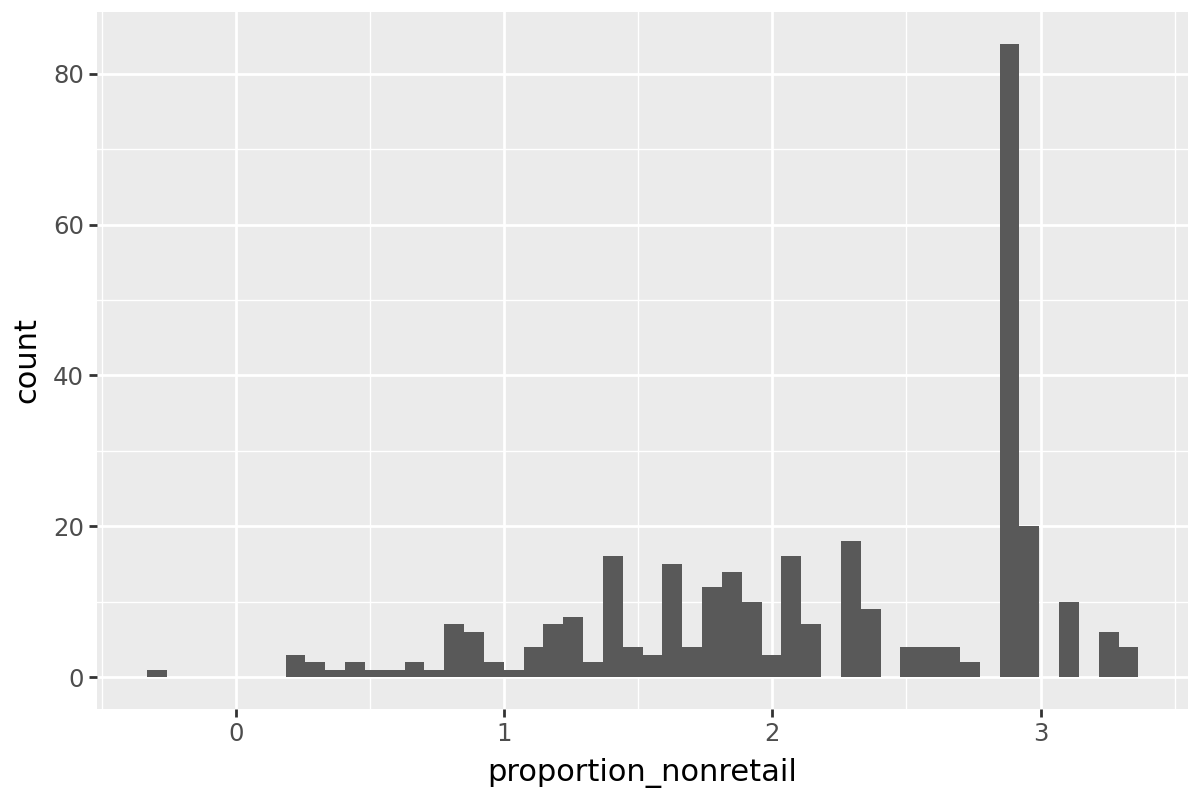

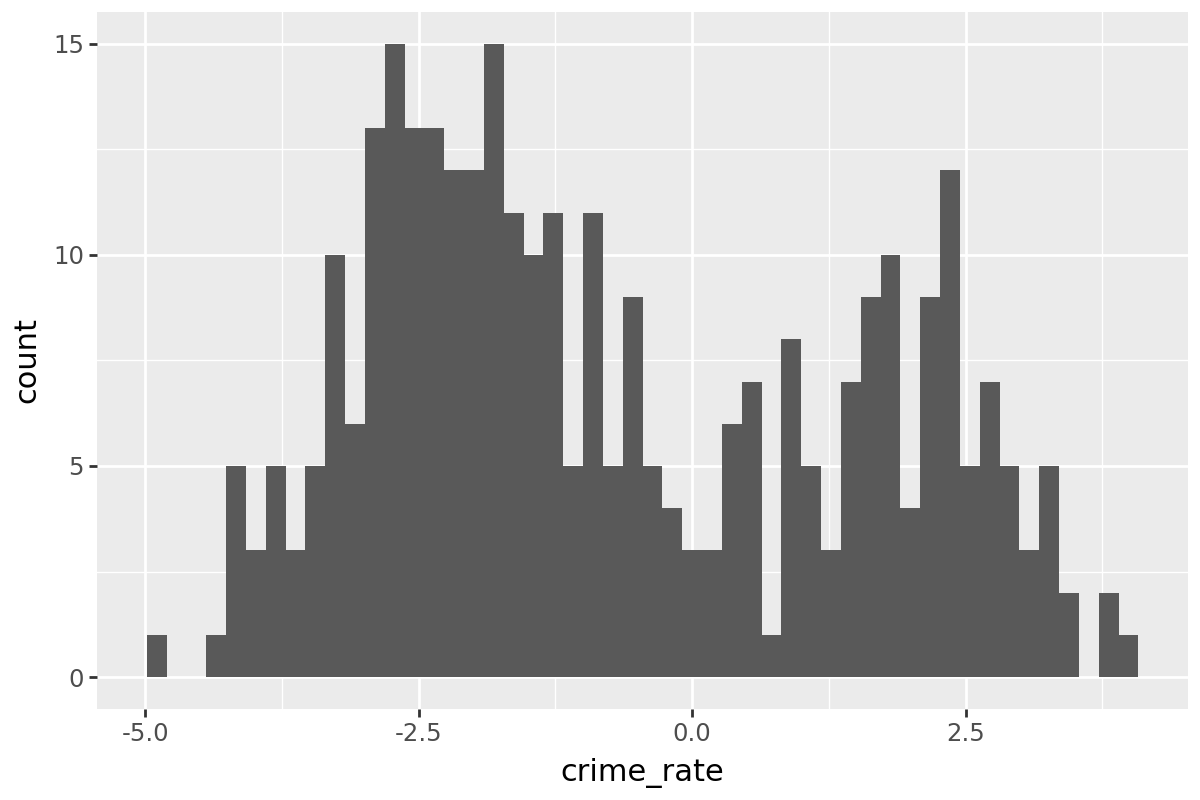

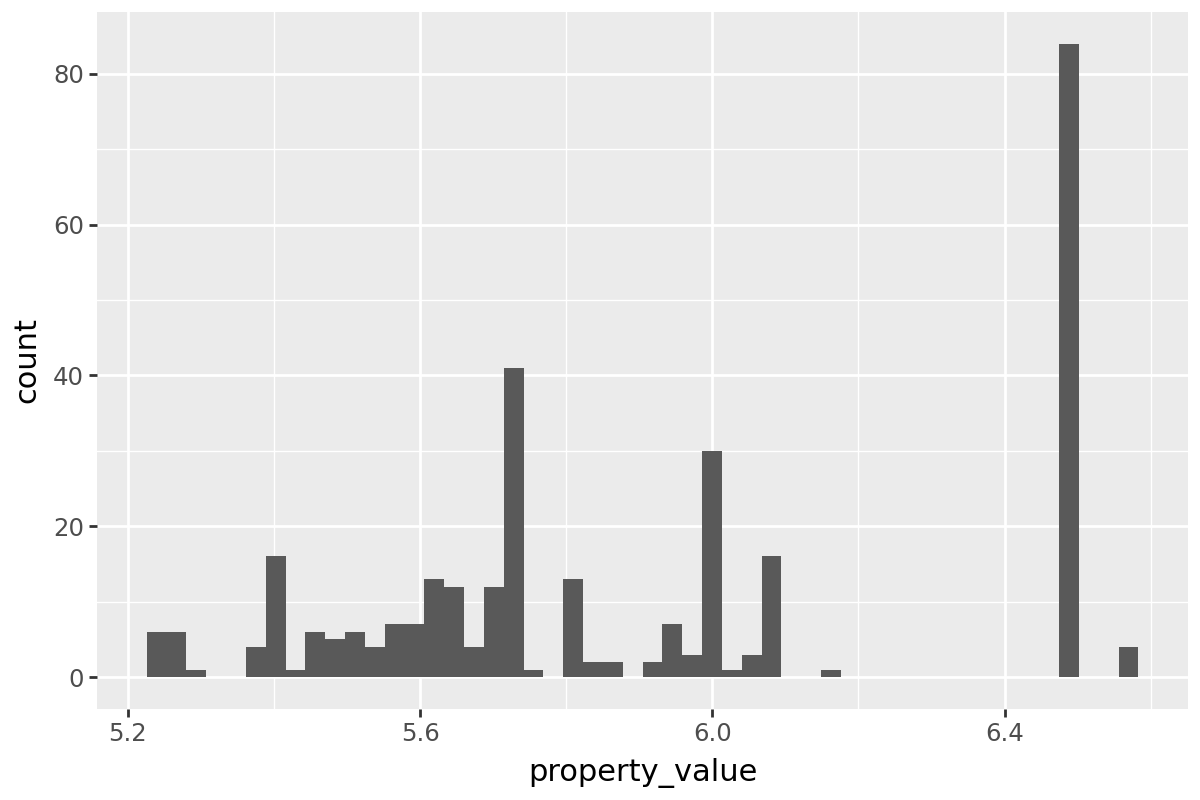

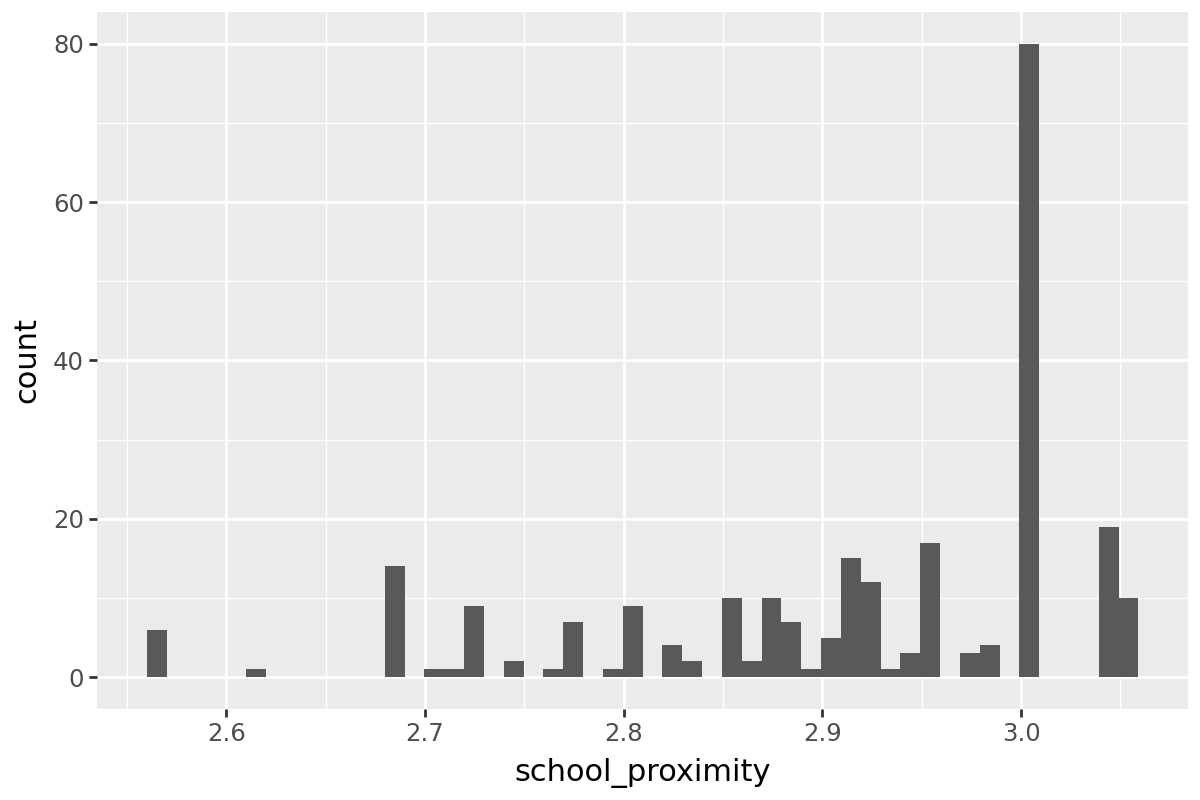

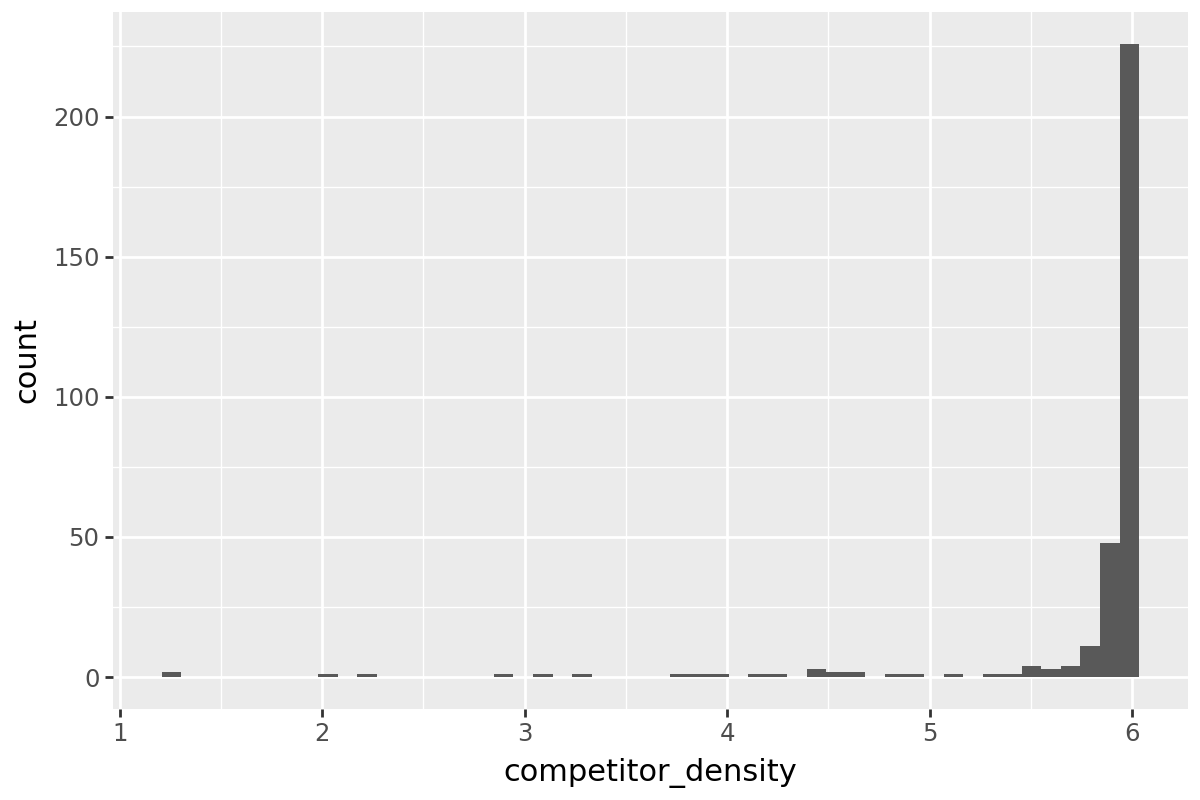

In [84]:
#Checking the distribution after transformation:
for var in columns_to_transform:
    
        plot=(
             p9.ggplot(raw_data)
            
            +p9.geom_bar(p9.aes(x=var),stat='bin', bins=50)
            +p9.theme(figure_size=(6,4))
        )

        display(plot)

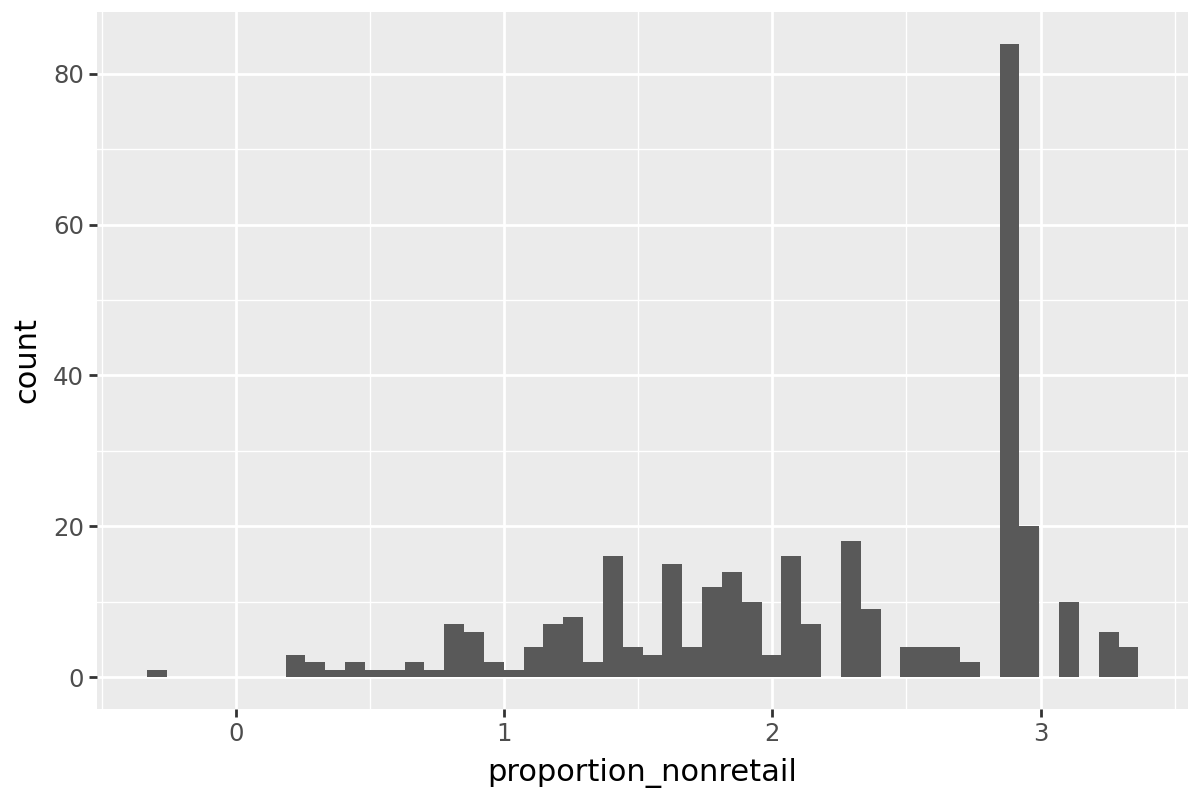

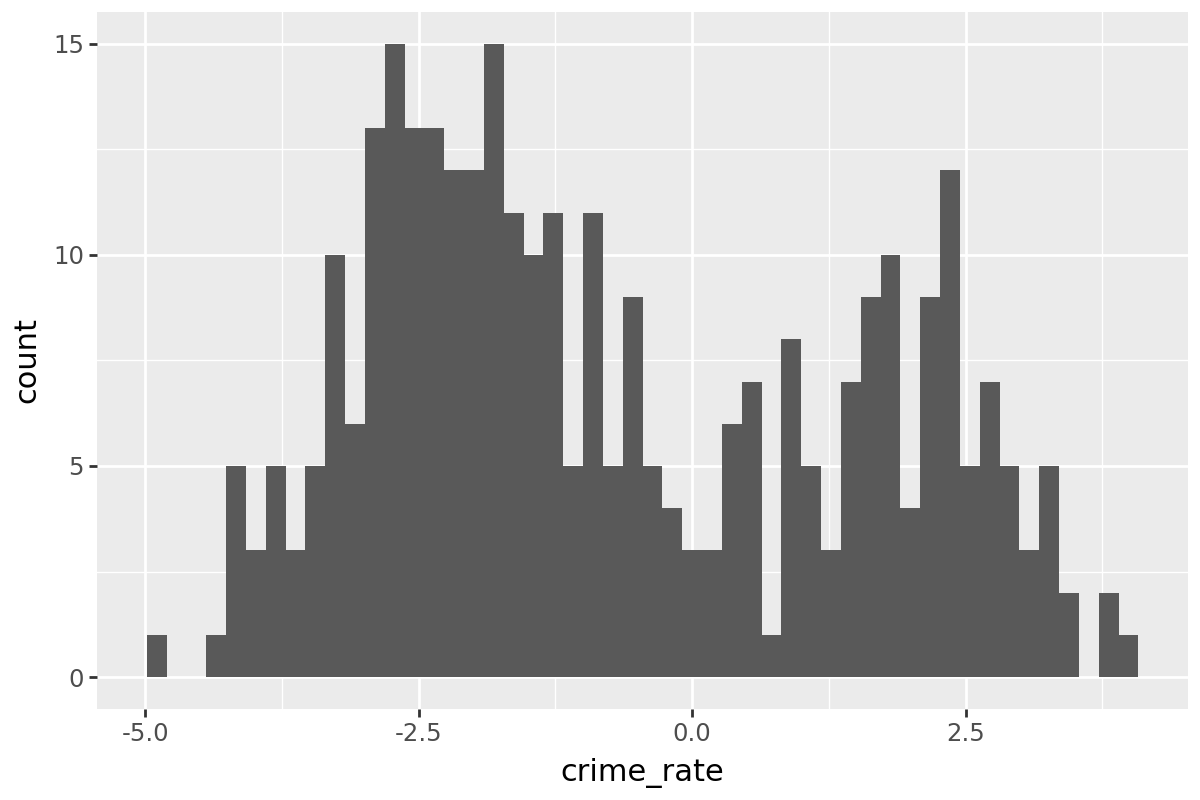

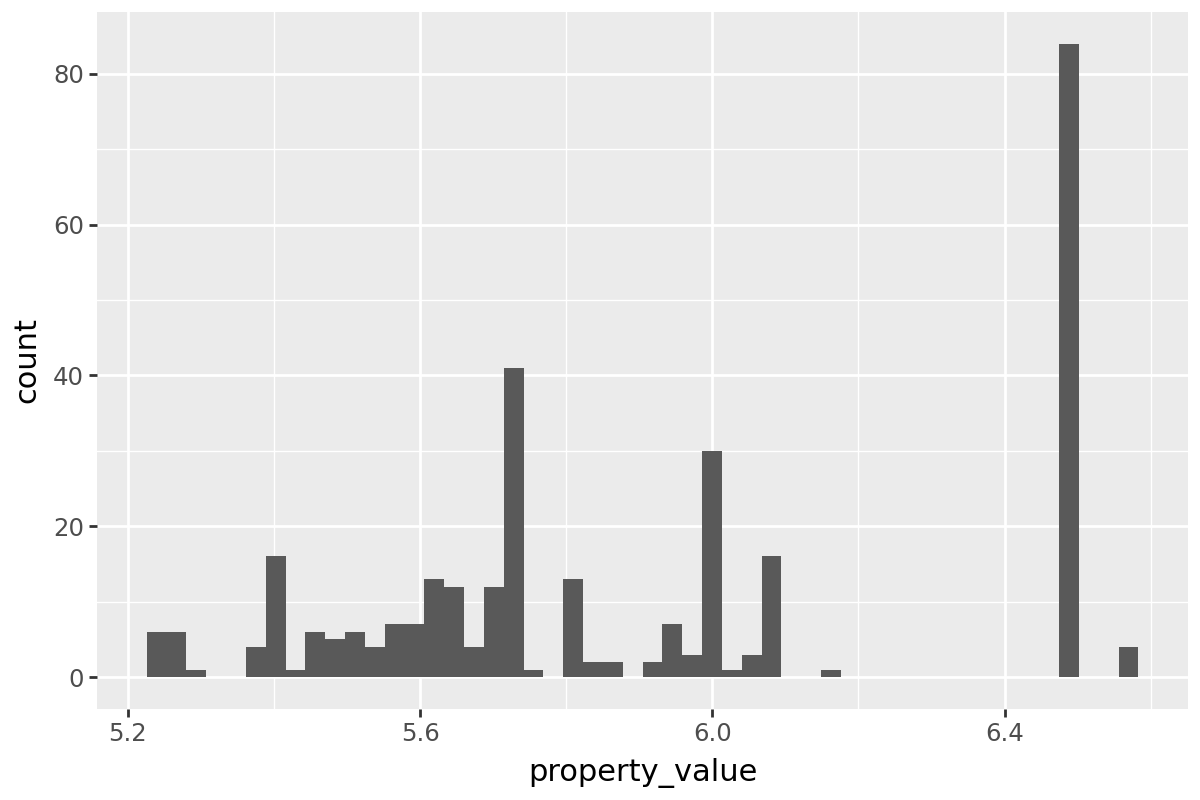

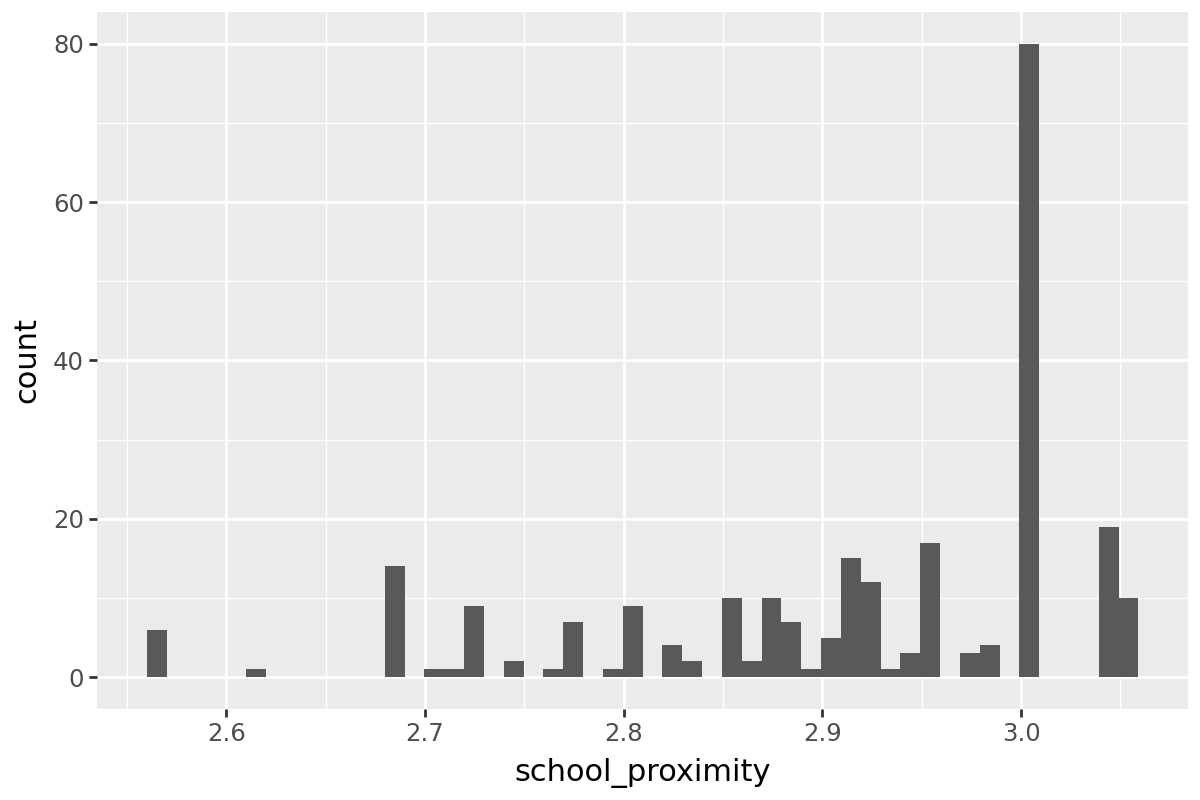

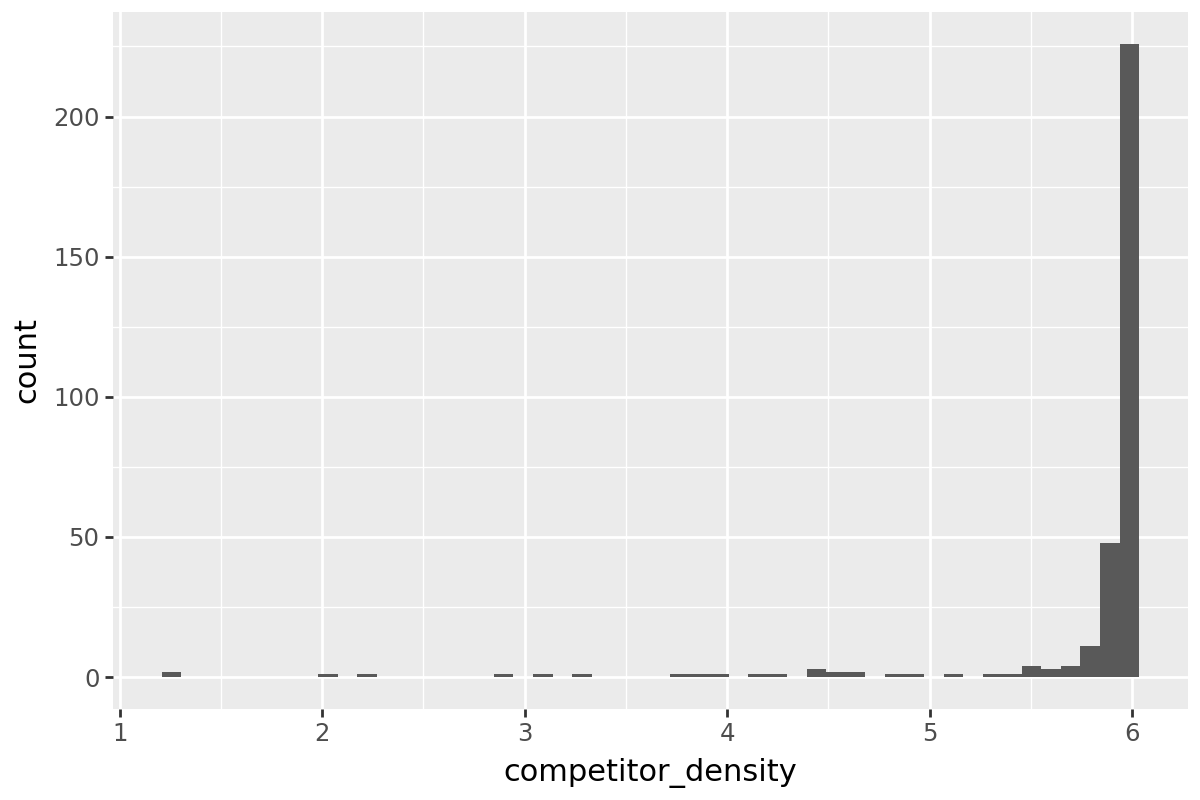

In [85]:
#Checking the distribution after transformation:
for var in columns_to_transform:
    print(
        (
             p9.ggplot(raw_data)
            +p9.aes(x=var)
            +p9.geom_bar(stat='bin', bins=50)
            +p9.theme(figure_size=(6,4))
        )
    )

* Crime_rate distribution is better but  is bimodal -> -2.5, +2.5 are the two approximate modes

## Missing value checks

In [29]:
len(raw_data.index)

320

In [8]:
(
raw_data
.isna()
.sum()
)

location_id                0
crime_rate                 0
proportion_flats           0
proportion_nonretail       0
new_store                  0
commercial_property       29
household_size             0
proportion_newbuilds       0
public_transport_dist      0
transport_availability     0
property_value             0
school_proximity          63
competitor_density         0
household_affluency        0
normalised_sales           0
county                     0
dtype: int64

### Missing values in the follwing columns: 
1. commercial_property - 10% missing
2. school_proximity - 20% missing

These columns need not be dropped. Missing values should be imputed

### Outlier Analysis

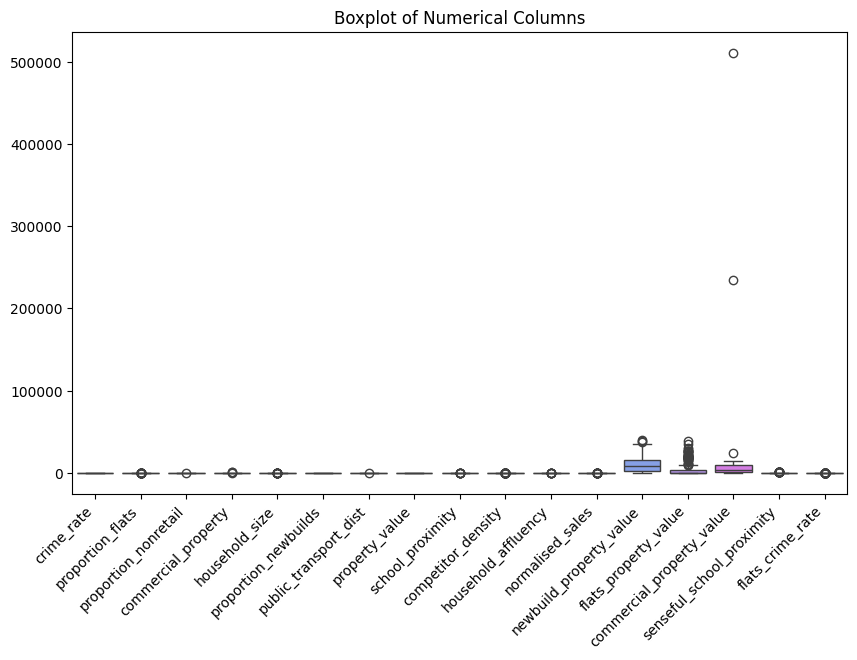

In [86]:

plt.figure(figsize=(10, 6))
sns.boxplot(data=raw_data[numerical_columns])
plt.title('Boxplot of Numerical Columns')
plt.xticks(rotation=45, ha="right")
plt.show()


### Notes on outliers: 
* Outlier needs to be handled for commercial_property, household_size, competitor_density

# Plan for modelling (MVP):
1. Missing values for school_proximity and commercial_property - Start with median imputation and check the model accuracy
2. Categorical encoding
    1. Binary encoding for new_store feature
    2. Ordinal encoding for transport_availability feature
3. Outlier handling if requred - not for MVP
4. Feature selection
5. Model development 

# Plan for Version 1.0

1. Feature engineering if required
2. Do Correlation analysis for Categorical features as well
3. Improve missing value handling if required
4. Handle outliers if required 
5. Check for linear relationships
6. Handling skewness